In [1]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# representation of model layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import joblib
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

2025-05-04 07:31:14.147437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746343874.385593      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746343874.451518      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **ĐỌC DỮ LIỆU 8 NHÃN**

📌 Nhãn Mirai: Thêm 13,351 dòng, tổng cộng 13,351 dòng
📌 Nhãn DDoS: Thêm 174,841 dòng, tổng cộng 174,841 dòng
📌 Nhãn Spoofing: Thêm 2,572 dòng, tổng cộng 2,572 dòng
📌 Nhãn BENIGN: Thêm 5,645 dòng, tổng cộng 5,645 dòng
📌 Nhãn DoS: Thêm 41,221 dòng, tổng cộng 41,221 dòng
📌 Nhãn Recon: Thêm 1,876 dòng, tổng cộng 1,876 dòng
📌 Nhãn BruteForce: Thêm 55 dòng, tổng cộng 55 dòng
📌 Nhãn Web-based: Thêm 105 dòng, tổng cộng 105 dòng
📌 File 0: Giữ 239,666 dòng sau khi lọc giới hạn
📌 Nhãn Recon: Thêm 1,888 dòng, tổng cộng 3,764 dòng
📌 Nhãn DoS: Thêm 41,933 dòng, tổng cộng 83,154 dòng
📌 Nhãn DDoS: Thêm 176,390 dòng, tổng cộng 351,231 dòng
📌 Nhãn Mirai: Thêm 13,615 dòng, tổng cộng 26,966 dòng
📌 Nhãn Spoofing: Thêm 2,544 dòng, tổng cộng 5,116 dòng
📌 Nhãn BENIGN: Thêm 5,778 dòng, tổng cộng 11,423 dòng
📌 Nhãn Web-based: Thêm 147 dòng, tổng cộng 252 dòng
📌 Nhãn BruteForce: Thêm 70 dòng, tổng cộng 125 dòng
📌 File 1: Giữ 242,365 dòng sau khi lọc giới hạn
📌 Nhãn DoS: Thêm 40,184 dòng, tổng cộng 123,338 dòng
📌

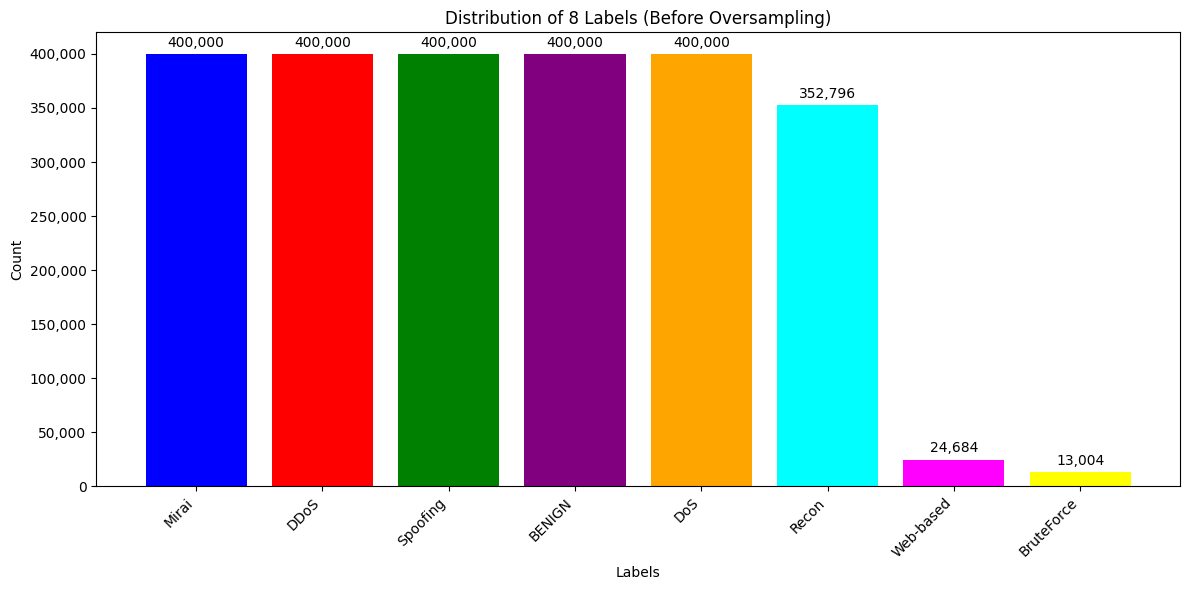

📌 Nhãn Mirai: Đã có 400,000 dòng, giữ nguyên
📌 Nhãn DDoS: Đã có 400,000 dòng, giữ nguyên
📌 Nhãn Spoofing: Đã có 400,000 dòng, giữ nguyên
📌 Nhãn BENIGN: Đã có 400,000 dòng, giữ nguyên
📌 Nhãn DoS: Đã có 400,000 dòng, giữ nguyên
📌 Oversampling nhãn Recon: Từ 352,796 lên 400,000 dòng
📌 Oversampling nhãn BruteForce: Từ 13,004 lên 400,000 dòng
📌 Oversampling nhãn Web-based: Từ 24,684 lên 400,000 dòng

📋 Phân bố nhãn sau khi cân bằng bằng oversampling:
label
DDoS          400000
BruteForce    400000
Mirai         400000
Web-based     400000
DoS           400000
Recon         400000
Spoofing      400000
BENIGN        400000
Name: count, dtype: int64


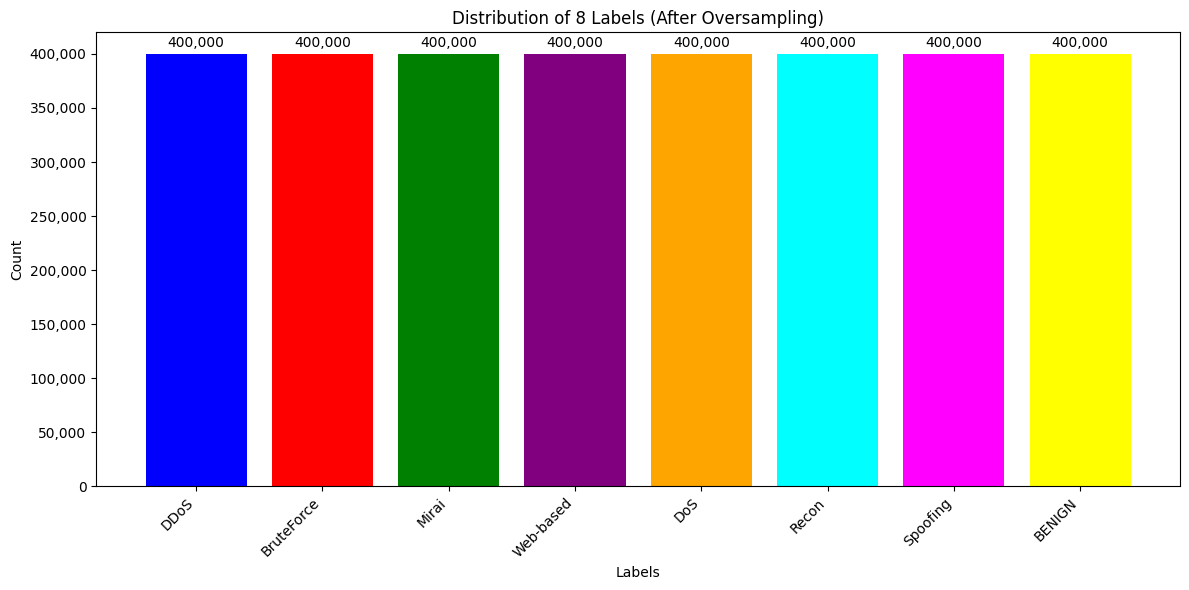

In [2]:


import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import cudf  # Dùng cuDF để xử lý dữ liệu nhanh hơn trên GPU
import numpy as np
from sklearn.utils import resample

# Định nghĩa thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Hàm ánh xạ nhãn thành 8 nhóm
def change_label(df):
    mapping = {
        'DDoS-ICMP_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS',
        'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-RSTFINFlood': 'DDoS',
        'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
        'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS',
        'DDoS-HTTP_Flood': 'DDoS', 'DDoS-SlowLoris': 'DDoS',
        'DoS-UDP_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS',
        'Recon-HostDiscovery': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
        'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon',
        'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing',
        'DictionaryBruteForce': 'BruteForce',
        'BrowserHijacking': 'Web-based', 'XSS': 'Web-based', 'Uploading_Attack': 'Web-based',
        'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based',
        'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai',
        'BenignTraffic': 'BENIGN'
    }
    df["label"] = df["label"].map(mapping).fillna(df["label"])
    return df

# Đọc dữ liệu từ thư mục
data_dir = "/kaggle/input/cic-iot-2023/"
file_list = glob.glob(f"{data_dir}*.csv")[:168]  # Lấy tối đa 134 file

# Giới hạn tối đa và tối thiểu 400,000 dòng cho mỗi nhãn
MAX_ROWS_PER_LABEL = 400_000
MIN_ROWS_PER_LABEL = 400_000
label_counts = {
    "DDoS": 0, "DoS": 0, "Recon": 0, "Spoofing": 0,
    "BruteForce": 0, "Web-based": 0, "Mirai": 0, "BENIGN": 0
}  # Theo dõi số dòng của từng nhãn

def read_file(filename, index):
    try:
        # Đọc file CSV bằng cuDF
        df = cudf.read_csv(filename)
        
        # Kiểm tra cột 'label'
        if 'label' not in df.columns:
            print(f"❌ File {filename}: Không tìm thấy cột 'label'!")
            return None
        
        # Ánh xạ nhãn thành 8 nhóm
        df = change_label(df)
        
        # Lọc dữ liệu dựa trên giới hạn 400K cho mỗi nhãn
        valid_rows = []
        unique_labels = df['label'].unique().to_pandas().tolist()
        for label in unique_labels:
            current_count = label_counts.get(label, 0)
            remaining_quota = MAX_ROWS_PER_LABEL - current_count
            
            if remaining_quota <= 0:
                print(f"⚠ Nhãn {label} đã đủ {MAX_ROWS_PER_LABEL:,} dòng, không đọc thêm!")
                continue
            
            # Lấy các dòng thuộc nhãn này
            label_df = df[df['label'] == label]
            rows_to_take = min(len(label_df), remaining_quota)
            
            if rows_to_take > 0:
                valid_rows.append(label_df[:rows_to_take])
                label_counts[label] = current_count + rows_to_take
                print(f"📌 Nhãn {label}: Thêm {rows_to_take:,} dòng, tổng cộng {label_counts[label]:,} dòng")
        
        # Gộp các dòng hợp lệ
        if valid_rows:
            df_filtered = cudf.concat(valid_rows, ignore_index=True)
            print(f"📌 File {index}: Giữ {df_filtered.shape[0]:,} dòng sau khi lọc giới hạn")
            return df_filtered
        else:
            print(f"⚠ File {index}: Không có dữ liệu nào được giữ lại!")
            return None
    except Exception as e:
        print(f"❌ Lỗi khi đọc file {filename}: {e}")
        return None

# Đọc tuần tự từng file
dfs = []
for idx, fname in enumerate(file_list):
    df = read_file(fname, idx)
    if df is not None:
        dfs.append(df)

# Nối dữ liệu và xử lý cân bằng
if dfs:
    df_full = cudf.concat(dfs, ignore_index=True)
    print(f"✅ Dữ liệu đã được nối! Kích thước: {df_full.shape}")
    print(f"📋 Nhãn duy nhất: {df_full['label'].unique().to_pandas().tolist()}")
    
    # Chuyển sang pandas để xử lý oversampling
    df_pandas = df_full.to_pandas()
    
    # Kiểm tra phân bố nhãn trước khi cân bằng
    print("\n📋 Phân bố nhãn trước khi cân bằng:")
    label_distribution = df_pandas["label"].value_counts()
    print(label_distribution)
    
    # Vẽ biểu đồ phân bố nhãn trước khi cân bằng
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(label_distribution.index, label_distribution.values, color=['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow'])
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of 8 Labels (Before Oversampling)')
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_before_oversampling.png')
    plt.show()
    
    # Chuẩn bị dữ liệu cho oversampling
    balanced_dfs = []
    unique_labels = df_pandas['label'].unique()
    
    # Áp dụng oversampling thủ công cho mỗi nhãn
    for label in unique_labels:
        label_df = df_pandas[df_pandas['label'] == label]
        current_count = len(label_df)
        
        if current_count < MIN_ROWS_PER_LABEL:
            # Oversampling bằng resample
            oversampled_df = resample(
                label_df,
                replace=True,  # Cho phép sao chép mẫu
                n_samples=MIN_ROWS_PER_LABEL,  # Đạt 400K
                random_state=42
            )
            print(f"📌 Oversampling nhãn {label}: Từ {current_count:,} lên {MIN_ROWS_PER_LABEL:,} dòng")
            balanced_dfs.append(oversampled_df)
        else:
            print(f"📌 Nhãn {label}: Đã có {current_count:,} dòng, giữ nguyên")
            balanced_dfs.append(label_df)
    
    # Gộp dữ liệu đã cân bằng
    df_balanced = pd.concat(balanced_dfs, ignore_index=True)
    
    # Chuyển lại thành cuDF để đồng bộ
    df_full = cudf.from_pandas(df_balanced)
    
    # Kiểm tra phân bố nhãn sau khi cân bằng
    print("\n📋 Phân bố nhãn sau khi cân bằng bằng oversampling:")
    balanced_label_distribution = df_full["label"].value_counts().to_pandas()
    print(balanced_label_distribution)
    
    # Vẽ biểu đồ phân bố nhãn sau khi cân bằng
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(balanced_label_distribution.index, balanced_label_distribution.values, color=['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow'])
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of 8 Labels (After Oversampling)')
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_after_oversampling.png')
    plt.show()
    
    # # Lưu df_full đã cân bằng để kiểm tra
    # df_full.to_pandas().to_csv(f'{output_dir}/balanced_data_8labels.csv', index=False)
    # print(f"✅ Dữ liệu đã cân bằng và lưu tại '{output_dir}/balanced_data_8labels.csv'")
    
else:
    print("⚠ Không có file nào được đọc thành công hoặc tất cả dữ liệu rỗng!")

# **ÁNH XẠ NHÃN**

📋 Nhãn duy nhất trong dữ liệu: ['Mirai', 'DDoS', 'Spoofing', 'BENIGN', 'DoS', 'Recon', 'BruteForce', 'Web-based']
📊 Các nhãn đã ánh xạ (8 nhãn):
  - BENIGN: 0
  - BruteForce: 1
  - DDoS: 2
  - DoS: 3
  - Mirai: 4
  - Recon: 5
  - Spoofing: 6
  - Web-based: 7

📊 Phân bố nhãn trong tập huấn luyện:
0    260000
4    260000
6    260000
7    260000
3    260000
1    260000
5    260000
2    260000
Name: count, dtype: int64

📊 Phân bố nhãn trong tập validation:
7    60000
5    60000
4    60000
1    60000
6    60000
2    60000
3    60000
0    60000
Name: count, dtype: int64

📊 Phân bố nhãn trong tập kiểm tra:
7    80000
1    80000
4    80000
3    80000
6    80000
2    80000
0    80000
5    80000
Name: count, dtype: int64
🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:
     flow_duration  Header_Length  Protocol Type  Duration          Rate  \
min      -0.082901      -0.077443      -0.922078 -1.855932     -0.269625   
max    2059.517632      69.790990       5.181818  5.347458  75595.755050   

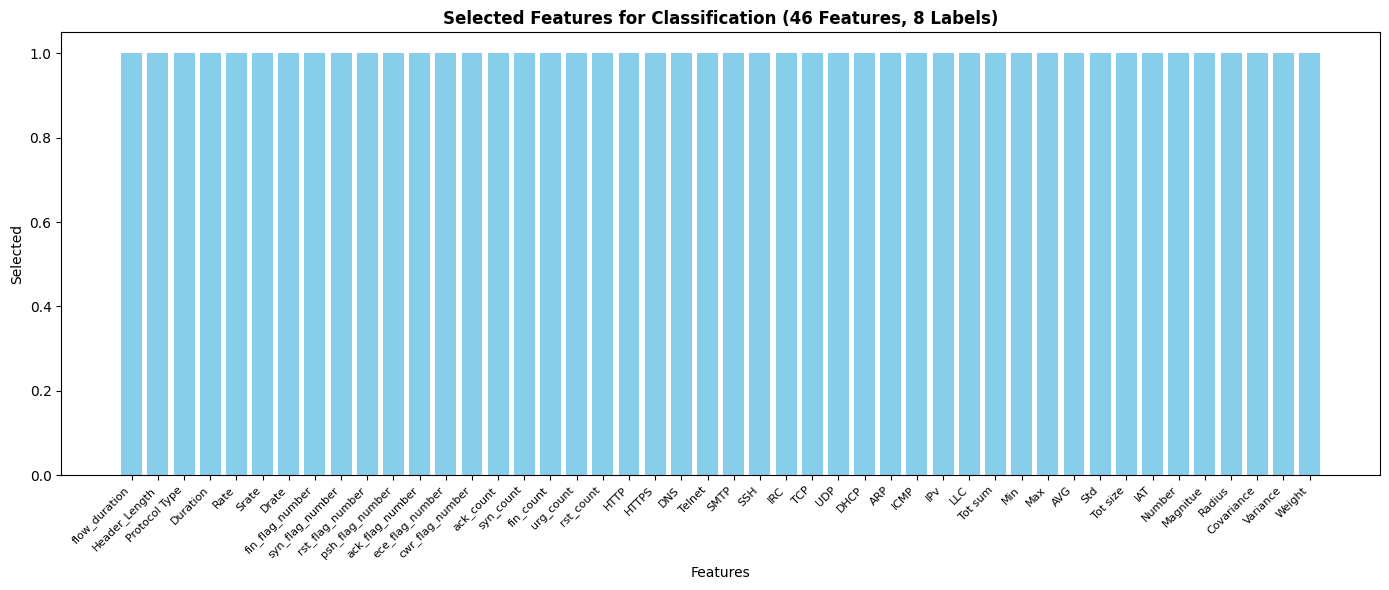

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
import pickle
import os
import matplotlib.pyplot as plt

# Đường dẫn lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Giả định df_full là DataFrame từ cell đọc dữ liệu trước đó (cuDF)
# Chuyển từ cuDF sang Pandas
df_original = df_full.to_pandas()

# Kiểm tra dữ liệu đầu vào
if df_original.empty or 'label' not in df_original.columns:
    raise ValueError("❌ Dữ liệu đầu vào rỗng hoặc thiếu cột 'label'!")

# Xử lý giá trị thiếu cho cột số
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
df_original[numeric_columns] = df_original[numeric_columns].fillna(df_original[numeric_columns].mean())

# Tách đặc trưng và nhãn
X = df_original.drop(columns=['label']).select_dtypes(include=[np.number])
y = df_original['label']

# Kiểm tra nhãn duy nhất
print("📋 Nhãn duy nhất trong dữ liệu:", y.unique().tolist())

# Danh sách 46 đặc trưng (giả định chọn 46 cột số đầu tiên hoặc từ bài toán 34 nhãn)
all_numeric_columns = X.columns.tolist()
if len(all_numeric_columns) < 46:
    raise ValueError(f"❌ Dữ liệu chỉ có {len(all_numeric_columns)} cột số, không đủ 46 đặc trưng!")
selected_features = all_numeric_columns[:46]  # Chọn 46 cột đầu tiên

# Kiểm tra xem các đặc trưng có tồn tại trong dữ liệu không
missing_features = [f for f in selected_features if f not in X.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không tồn tại trong dữ liệu: {missing_features}")

# Lấy chỉ số của các đặc trưng đã chọn
feature_indices = [list(X.columns).index(f) for f in selected_features]

# Áp dụng các đặc trưng đã chọn trước khi chia dữ liệu
X = X[selected_features]

# Chia dữ liệu thành tập train, val, test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1875, stratify=Y_temp, random_state=42)

# Mã hóa nhãn (8 nhãn: DDoS, DoS, Recon, Spoofing, BruteForce, Web-based, Mirai, BENIGN)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# In ra các nhãn đã ánh xạ
print("📊 Các nhãn đã ánh xạ (8 nhãn):")
for label, encoded_value in label_mapping.items():
    print(f"  - {label}: {encoded_value}")

# Kiểm tra phân bố nhãn
print("\n📊 Phân bố nhãn trong tập huấn luyện:")
print(pd.Series(Y_train_encoded).value_counts().rename(label_mapping))
print("\n📊 Phân bố nhãn trong tập validation:")
print(pd.Series(Y_val_encoded).value_counts().rename(label_mapping))
print("\n📊 Phân bố nhãn trong tập kiểm tra:")
print(pd.Series(Y_test_encoded).value_counts().rename(label_mapping))

# Xử lý NaN và outlier bằng KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Kiểm tra giá trị sau khi chọn đặc trưng
print("🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:")
print(pd.DataFrame(X_train_scaled, columns=selected_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:")
print(pd.DataFrame(X_val_scaled, columns=selected_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_test_scaled:")
print(pd.DataFrame(X_test_scaled, columns=selected_features).describe().loc[['min', 'max']])

# Lưu dữ liệu đã xử lý
np.save(f"{output_dir}/X_train_scaled_8labels_46features.npy", X_train_scaled)
np.save(f"{output_dir}/Y_train_encoded_8labels_46features.npy", Y_train_encoded)
np.save(f"{output_dir}/X_val_scaled_8labels_46features.npy", X_val_scaled)
np.save(f"{output_dir}/Y_val_encoded_8labels_46features.npy", Y_val_encoded)
np.save(f"{output_dir}/X_test_scaled_8labels_46features.npy", X_test_scaled)
np.save(f"{output_dir}/Y_test_encoded_8labels_46features.npy", Y_test_encoded)

# Lưu các đối tượng xử lý
with open(f"{output_dir}/label_encoder_8labels_46features.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)
with open(f"{output_dir}/scaler_8labels_46features.pkl", 'wb') as f:
    pickle.dump(scaler, f)
with open(f"{output_dir}/imputer_8labels_46features.pkl", 'wb') as f:
    pickle.dump(imputer, f)
with open(f"{output_dir}/selected_features_8labels_46features.pkl", 'wb') as f:
    pickle.dump(selected_features, f)

# In thông tin chi tiết
print(f"✅ Dữ liệu đã xử lý và lưu trong '{output_dir}'!")
print(f"📌 Số đặc trưng được chọn: {len(selected_features)}")
print(f"📋 Các đặc trưng được chọn: {selected_features}")

# Vẽ biểu đồ danh sách đặc trưng được chọn
plt.figure(figsize=(14, 6))
plt.bar(selected_features, [1] * len(selected_features), color='skyblue')
plt.title('Selected Features for Classification (46 Features, 8 Labels)', fontsize=12, fontweight='bold')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Selected', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.savefig(f"{output_dir}/selected_features_8labels_46features.png")
plt.show()

# **CHUYỂN ĐỔI ĐẶC TRƯNG FUZZY**

In [ ]:
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Tải dữ liệu đã xử lý (46 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_8labels_46features.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_8labels_46features.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_8labels_46features.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")

# Kiểm tra shape
print(f"📌 Shape dữ liệu đầu vào:")
print(f"  - X_train_scaled: {X_train_scaled.shape}")
print(f"  - X_val_scaled: {X_val_scaled.shape}")
print(f"  - X_test_scaled: {X_test_scaled.shape}")

# Chia 46 đặc trưng thành 8 nhóm (7 nhóm 6 đặc trưng, 1 nhóm 4 đặc trưng)
n_groups = 8
group_sizes = [6] * 7 + [4]  # [6, 6, 6, 6, 6, 6, 6, 4]
X_train_grouped = []
X_val_grouped = []
X_test_grouped = []

print("🔄 Tạo đặc trưng xác suất nhóm bằng XGBoost...")
for i in range(n_groups):
    start_idx = sum(group_sizes[:i])
    end_idx = start_idx + group_sizes[i]
    X_train_group = X_train_scaled[:, start_idx:end_idx]
    X_val_group = X_val_scaled[:, start_idx:end_idx]
    X_test_group = X_test_scaled[:, start_idx:end_idx]

    print(f"  - Nhóm {i+1}: Đặc trưng từ {start_idx} đến {end_idx-1} (kích thước: {group_sizes[i]})")

    # Huấn luyện XGBoost trên nhóm đặc trưng
    xgb = XGBClassifier(
        n_estimators=50,
        max_depth=8,
        min_child_weight=10,
        tree_method="hist",
        device="cuda",
        random_state=42,
        objective="multi:softprob"
    )
    xgb.fit(X_train_group, Y_train_encoded)

    # Tạo xác suất dự đoán
    train_probs = xgb.predict_proba(X_train_group)  # Shape: [n_samples, 8]
    val_probs = xgb.predict_proba(X_val_group)
    test_probs = xgb.predict_proba(X_test_group)

    X_train_grouped.append(train_probs)
    X_val_grouped.append(val_probs)
    X_test_grouped.append(test_probs)

    # Lưu mô hình XGBoost
    joblib.dump(xgb, f"{output_dir}/xgb_group_{i}_8labels_46features.joblib")
    print(f"✅ Đã xử lý nhóm {i+1}/{n_groups}")

# Gộp đặc trưng xác suất
X_train_grouped = np.concatenate(X_train_grouped, axis=1)  # Shape: [n_samples, 8*8 = 64]
X_val_grouped = np.concatenate(X_val_grouped, axis=1)
X_test_grouped = np.concatenate(X_test_grouped, axis=1)

# (Tùy chọn) Kết hợp với top-k đặc trưng gốc
k = 10  # Chọn 10 đặc trưng quan trọng nhất
xgb_full = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    tree_method="hist",
    device="cuda",
    random_state=42
)
xgb_full.fit(X_train_scaled, Y_train_encoded)
feature_importance = xgb_full.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1][:k]

# Kết hợp đặc trưng xác suất và đặc trưng gốc
X_train_combined = np.concatenate([X_train_grouped, X_train_scaled[:, sorted_idx]], axis=1)  # Shape: [n_samples, 64+10 = 74]
X_val_combined = np.concatenate([X_val_grouped, X_val_scaled[:, sorted_idx]], axis=1)
X_test_combined = np.concatenate([X_test_grouped, X_test_scaled[:, sorted_idx]], axis=1)

# Chuẩn hóa lại dữ liệu
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

# Lưu dữ liệu
np.save(f"{output_dir}/X_train_combined_8labels_46features.npy", X_train_combined)
np.save(f"{output_dir}/X_val_combined_8labels_46features.npy", X_val_combined)
np.save(f"{output_dir}/X_test_combined_8labels_46features.npy", X_test_combined)
np.save(f"{output_dir}/Y_train_encoded_8labels_46features.npy", Y_train_encoded)
np.save(f"{output_dir}/Y_val_encoded_8labels_46features.npy", Y_val_encoded)
np.save(f"{output_dir}/Y_test_encoded_8labels_46features.npy", Y_test_encoded)
joblib.dump(scaler, f"{output_dir}/scaler_combined_8labels_46features.joblib")

# In thông tin
print(f"✅ Đã tạo đặc trưng kết hợp!")
print(f"📌 Shape: train {X_train_combined.shape}, val {X_val_combined.shape}, test {X_test_combined.shape}")
print(f"📌 Số đặc trưng: {X_train_combined.shape[1]} (64 xác suất + 10 gốc)")

In [ ]:
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Tải dữ liệu đã xử lý (46 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_8labels_46features.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_8labels_46features.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_8labels_46features.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")

# Kiểm tra shape
print(f"📌 Shape dữ liệu đầu vào:")
print(f"  - X_train_scaled: {X_train_scaled.shape}")
print(f"  - X_val_scaled: {X_val_scaled.shape}")
print(f"  - X_test_scaled: {X_test_scaled.shape}")

# Chia 46 đặc trưng thành 8 nhóm (7 nhóm 6 đặc trưng, 1 nhóm 4 đặc trưng)
n_groups = 8
group_sizes = [6] * 7 + [4]  # [6, 6, 6, 6, 6, 6, 6, 4]
X_train_grouped = []
X_val_grouped = []
X_test_grouped = []

print("🔄 Tạo đặc trưng xác suất nhóm bằng XGBoost...")
for i in range(n_groups):
    start_idx = sum(group_sizes[:i])
    end_idx = start_idx + group_sizes[i]
    X_train_group = X_train_scaled[:, start_idx:end_idx]
    X_val_group = X_val_scaled[:, start_idx:end_idx]
    X_test_group = X_test_scaled[:, start_idx:end_idx]

    print(f"  - Nhóm {i+1}: Đặc trưng từ {start_idx} đến {end_idx-1} (kích thước: {group_sizes[i]})")

    # Huấn luyện XGBoost trên nhóm đặc trưng
    xgb = XGBClassifier(
        n_estimators=50,
        max_depth=8,
        min_child_weight=10,
        tree_method="hist",
        device="cuda",
        random_state=42,
        objective="multi:softprob"
    )
    xgb.fit(X_train_group, Y_train_encoded)

    # Tạo xác suất dự đoán
    train_probs = xgb.predict_proba(X_train_group)  # Shape: [n_samples, 8]
    val_probs = xgb.predict_proba(X_val_group)
    test_probs = xgb.predict_proba(X_test_group)

    X_train_grouped.append(train_probs)
    X_val_grouped.append(val_probs)
    X_test_grouped.append(test_probs)

    # Lưu mô hình XGBoost
    joblib.dump(xgb, f"{output_dir}/xgb_group_{i}_8labels_46features.joblib")
    print(f"✅ Đã xử lý nhóm {i+1}/{n_groups}")

# Gộp đặc trưng xác suất
X_train_combined = np.concatenate(X_train_grouped, axis=1)  # Shape: [n_samples, 8*8 = 64]
X_val_combined = np.concatenate(X_val_grouped, axis=1)
X_test_combined = np.concatenate(X_test_grouped, axis=1)

# Chuẩn hóa lại dữ liệu
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

# Lưu dữ liệu
np.save(f"{output_dir}/X_train_combined_8labels_46features.npy", X_train_combined)
np.save(f"{output_dir}/X_val_combined_8labels_46features.npy", X_val_combined)
np.save(f"{output_dir}/X_test_combined_8labels_46features.npy", X_test_combined)
np.save(f"{output_dir}/Y_train_encoded_8labels_46features.npy", Y_train_encoded)
np.save(f"{output_dir}/Y_val_encoded_8labels_46features.npy", Y_val_encoded)
np.save(f"{output_dir}/Y_test_encoded_8labels_46features.npy", Y_test_encoded)
joblib.dump(scaler, f"{output_dir}/scaler_combined_8labels_46features.joblib")

# In thông tin
print(f"✅ Đã tạo đặc trưng xác suất!")
print(f"📌 Shape: train {X_train_combined.shape}, val {X_val_combined.shape}, test {X_test_combined.shape}")
print(f"📌 Số đặc trưng: {X_train_combined.shape[1]} (64 xác suất)")

# **MÔ HÌNH TABNET**

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 88.53 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.1004
Val Loss trung bình: 0.1024
Train Accuracy trung bình: 96.27%
Val Accuracy trung bình: 96.24%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Entmax
def entmax15(x, dim=-1):
    x = F.softmax(x * 1.5, dim=dim)
    return x

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# TabNet thuần túy
class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes, n_d=64, n_a=64, n_steps=5, gamma=1.3, lambda_sparse=1e-8):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse

        # BatchNorm đầu vào
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)

        # Lớp FC ban đầu
        self.initial_fc = nn.Linear(input_dim, n_d + n_a)
        nn.init.xavier_normal_(self.initial_fc.weight)
        nn.init.zeros_(self.initial_fc.bias)

        # Các lớp chú ý (attention) và quyết định (decision) cho từng bước
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_a, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.ReLU()
            ) for _ in range(n_steps)
        ])
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Dropout(0.2)
            ) for _ in range(n_steps)
        ])

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(n_d * n_steps, n_d)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(n_d * n_steps, num_classes)  # Dùng trong Stage 2
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        prior = torch.ones_like(x)
        outputs = []
        sparsity_loss = 0
        masks = []

        for step in range(self.n_steps):
            # Tạo đặc trưng chú ý và quyết định
            att = self.initial_fc(x)
            att_d, att_a = att[:, :self.n_d], att[:, self.n_d:]
            mask = self.attention_layers[step](att_a)
            mask = entmax15(mask, dim=1)
            
            # Tính sparsity loss
            entropy = -torch.sum(mask * torch.log(mask + 1e-8), dim=1)
            sparsity_loss += torch.mean(entropy) / self.n_steps / self.input_dim
            masks.append(mask)

            # Cập nhật prior và áp dụng mask
            prior = prior * (self.gamma - mask)
            masked_x = x * mask

            # Tạo đầu ra quyết định
            out = self.decision_layers[step](masked_x)
            outputs.append(out)

        # Kết hợp đầu ra từ tất cả các bước
        combined = torch.cat(outputs, dim=1)  # [batch_size, n_d * n_steps]

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(combined)
        else:  # stage == 'classification'
            output = self.fc_output(combined)

        return output, sparsity_loss, masks

# Tải dữ liệu (8 nhãn, 30 đặc trưng)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_8labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_8labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_8labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels từ XGBoost (8 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_8labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_8labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_8labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")

# Nối soft labels vào đặc trưng đầu vào
X_train_aug = np.concatenate([X_train_scaled, soft_labels_train], axis=1)  # Shape: (n_train, 38)
X_val_aug = np.concatenate([X_val_scaled, soft_labels_val], axis=1)        # Shape: (n_val, 38)
X_test_aug = np.concatenate([X_test_scaled, soft_labels_test], axis=1)      # Shape: (n_test, 38)
tqdm.write(f"✅ Đã nối soft labels vào đặc trưng, shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 38 đặc trưng (30 + 8 soft labels)
model = TabNet(input_dim=input_dim, num_classes=8, n_d=64, n_a=64, n_steps=5).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_ce = nn.CrossEntropyLoss()  # Dùng cho phân loại đa lớp
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.1  # Giữ nguyên từ mã trước
temperature = 5.0  # Giữ nguyên từ mã trước

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with CE + KL + Sparsity Loss
tqdm.write("Stage 2: Classification with CE + KL + Sparsity Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            ce_loss = criterion_ce(outputs, Y_batch)  # CrossEntropyLoss cho đa lớp
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels, reduction='batchmean'), min=0.0)
            loss = ce_loss + distillation_weight * kl_loss + model.lambda_sparse * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                ce_loss = criterion_ce(outputs, Y_batch)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels, reduction='batchmean'), min=0.0)
                loss = ce_loss + distillation_weight * kl_loss + model.lambda_sparse * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)  # 8 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/tabnet_8labels_with_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/tabnet_8labels_with_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/tabnet_8labels_with_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_8labels_with_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_with_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_with_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_with_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_8labels_with_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_8labels_with_soft_label_input.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/tabnet_8labels_with_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(outputs, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())  # Lưu logits
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=8)  # 8 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_8labels_with_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_with_soft_label_input.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_8labels_with_soft_label_input.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_8labels_with_soft_label_input.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_8labels_with_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ TABNET**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_with_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_with_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_with_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_with_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_with_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_with_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_with_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_8labels_with_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_with_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho TabNet (8 nhãn, với soft label input)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'BENIGN',
    1: 'BruteForce',
    2: 'DDoS',
    3: 'DoS',
    4: 'Mirai',
    5: 'Recon',
    6: 'Spoofing',
    7: 'Web-based'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Tăng kích thước để dễ đọc

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Learning Curve - Loss", fontsize=14)
ax1.legend(loc="upper right", fontsize=10)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
# Điều chỉnh trục Y dựa trên giá trị thực tế
loss_min = min(train_losses_plot.min(), val_losses_plot.min())
loss_max = max(train_losses_plot.max(), val_losses_plot.max())
ax1.set_ylim(loss_min - 0.005, loss_max + 0.005)  # Thêm padding nhỏ để dễ nhìn

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Learning Curve - Accuracy", fontsize=14)
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
# Điều chỉnh trục Y dựa trên giá trị thực tế
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
ax2.set_ylim(acc_min - 0.5, acc_max + 0.5)  # Thêm padding nhỏ để dễ nhìn

# Thêm tiêu đề chính
plt.suptitle("TabNet: Learning Curves (8 Labels, With Soft Label Input)\nStage 2 (Epoch 5 to 105, Mapped to 0-100)", 
             fontsize=14, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_tabnet_8labels_with_soft_label_input.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("TabNet: Confusion Matrix (Test, 8 Labels)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_tabnet_8labels_with_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(10, 8))  # Tăng kích thước biểu đồ
roc_auc_scores = []
for i in range(8):
    # Tính ROC cho từng nhãn (one-vs-rest)
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    roc_auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

# Tính ROC-AUC trung bình (macro-average)
roc_auc_macro = np.mean(roc_auc_scores)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"TabNet: ROC Curves (8 Labels, Macro AUC = {roc_auc_macro:.4f})", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
# Thu hẹp trục X từ 0 đến 0.2
plt.xlim(0, 0.2)
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_tabnet_8labels_with_soft_label_input.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Scores (One-vs-Rest):")
for i, score in enumerate(roc_auc_scores):
    print(f"{class_names[i]}: {score:.4f}")
print(f"📈 Macro-average ROC-AUC: {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("TabNet: PCA 3D Visualization (8 Labels)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_tabnet_8labels_with_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH AUTOINT**

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 71.91 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0019
Val Loss trung bình: 0.0019
Train Accuracy trung bình: 93.85%
Val Accuracy trung bình: 94.28%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.05):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# AutoInt (Automatic Feature Interaction Learning)
class AutoInt(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, n_layers=3, n_heads=4, dropout=0.1):
        super(AutoInt, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout

        # Ghost Batch Normalization
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)

        # Embedding layer
        self.embedding = nn.Linear(input_dim, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight)

        # Multi-Head Self-Attention layers
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, dropout=dropout, batch_first=True)
            for _ in range(n_layers)
        ])
        self.attention_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.dropout_layer = nn.Dropout(dropout)

        # Feature importance
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

        # Fully connected layers
        self.fc_embed = nn.Linear(embed_dim, embed_dim)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(embed_dim, num_classes)  # Dùng trong Stage 2
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        # Ghost Batch Normalization
        x = torch.clamp(self.bn(x), -50, 50)  # [batch_size, input_dim]

        # Feature importance
        importance = torch.sigmoid(self.importance_layer(x))  # [batch_size, input_dim]
        sparsity_loss = torch.mean(-importance * torch.log(importance + 1e-8))
        masks = [importance]

        # Embedding
        x_embed = self.embedding(x).unsqueeze(1)  # [batch_size, 1, embed_dim]

        # Multi-Head Self-Attention
        for attn, norm in zip(self.attention_layers, self.attention_norms):
            attn_output, _ = attn(x_embed, x_embed, x_embed)  # [batch_size, 1, embed_dim]
            x_embed = norm(x_embed + self.dropout_layer(attn_output))  # Residual + LayerNorm

        embeddings = x_embed.squeeze(1)  # [batch_size, embed_dim]

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(embeddings)
        else:  # stage == 'classification'
            output = self.fc_output(embeddings)

        return output, sparsity_loss, masks

# Tải dữ liệu (8 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_8labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_8labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_8labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn (8 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels (8 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_8labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_8labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_8labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir} (8 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")
if soft_labels_train.shape[1] != 8:
    raise ValueError(f"Soft labels phải có 8 cột (cho 8 nhãn), nhưng có {soft_labels_train.shape[1]} cột")

# Nối soft labels vào đầu vào
X_train_aug = np.concatenate([X_train_scaled, soft_labels_train], axis=1)  # Shape: (n_train, 30 + 8)
X_val_aug = np.concatenate([X_val_scaled, soft_labels_val], axis=1)
X_test_aug = np.concatenate([X_test_scaled, soft_labels_test], axis=1)
tqdm.write(f"✅ Input shape (sau khi nối soft labels): train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Tính alpha cho Focal Loss (cho 8 nhãn)
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 30 đặc trưng + 8 soft labels = 38
model = AutoInt(input_dim=input_dim, num_classes=8, embed_dim=192, n_layers=3, n_heads=4, dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=5e-7)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.05)
criterion_contrast = ContrastiveLoss(margin=1.0)

# Tham số huấn luyện
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.001
temperature = 2.0

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
torch.manual_seed(44)
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Tính accuracy trong Stage 1
            with torch.no_grad():
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation trong Stage 1
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, _ in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                # Tính contrastive loss để báo cáo (không dùng để tối ưu)
                idx_val = torch.randperm(X_batch.size(0))
                X_batch_2 = X_batch[idx_val]
                Y_batch_2 = Y_batch[idx_val]
                label = (Y_batch == Y_batch_2).float()
                features, _, _ = model(X_batch, stage='feature_learning')
                features_2, _, _ = model(X_batch_2, stage='feature_learning')
                loss = criterion_contrast(features, features_2, label)
                running_val_loss += loss.item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

# Stage 2: Classification with Focal + KL + Sparsity Loss
tqdm.write("Stage 2: Classification with Focal + KL + Sparsity Loss (Reduced Soft Label Influence)")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            focal_loss = criterion_focal(outputs, Y_batch)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = focal_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean()
                ce_loss = F.cross_entropy(outputs, Y_batch, reduction='none', label_smoothing=0.05).mean()
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Sparsity Loss: {sparsity_loss.item():.4f}, Focal Loss: {focal_loss.item():.4f}, "
                          f"CE Loss: {ce_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}, Grad Norm: {grad_norm:.4f}, "
                          f"Running Loss: {running_loss:.4f}, "
                          f"Mask max/min: {masks[-1].max():.4f}/{masks[-1].min():.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                focal_loss = criterion_focal(outputs, Y_batch)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = focal_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)  # 8 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/autoint_8labels_with_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/autoint_8labels_with_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/autoint_8labels_with_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_8labels_with_soft_label_input_autoint.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_with_soft_label_input_autoint.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_with_soft_label_input_autoint.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_with_soft_label_input_autoint.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_8labels_with_soft_label_input_autoint.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_8labels_with_soft_label_input_autoint.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_8labels_with_soft_label_input_autoint.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/autoint_8labels_with_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            embed_features, _, _ = model(X_batch, stage='feature_learning')  # Lấy embedding từ Stage 1
            probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(embed_features.detach().cpu().numpy())  # Lưu embedding thay vì logits
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=8)  # 8 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

# Kiểm tra kích thước Confusion Matrix
tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (8, 8):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (8,8), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_8labels_with_soft_label_input_autoint.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_with_soft_label_input_autoint.npy", test_probs)
np.save(f"{results_dir}/test_labels_8labels_with_soft_label_input_autoint.npy", test_labels)
np.save(f"{results_dir}/test_features_8labels_with_soft_label_input_autoint.npy", test_features)
np.save(f"{results_dir}/feature_importance_8labels_with_soft_label_input_autoint.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**·VẼ CÁC SƠ ĐỒ AUTOINT**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_with_soft_label_input_autoint.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_with_soft_label_input_autoint.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_with_soft_label_input_autoint.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_with_soft_label_input_autoint.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_with_soft_label_input_autoint.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_with_soft_label_input_autoint.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_with_soft_label_input_autoint.npy")
    test_features = np.load(f"{results_dir}/test_features_8labels_with_soft_label_input_autoint.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_with_soft_label_input_autoint.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho AutoInt (8 nhãn, với soft label input)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'BENIGN',
    1: 'BruteForce',
    2: 'DDoS',
    3: 'DoS',
    4: 'Mirai',
    5: 'Recon',
    6: 'Spoofing',
    7: 'Web-based'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Tăng kích thước để dễ đọc

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Learning Curve - Loss", fontsize=14)
ax1.legend(loc="upper right", fontsize=10)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
# Điều chỉnh trục Y theo yêu cầu: từ 0.00 đến 0.004
ax1.set_ylim(0.0016, 0.0026)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Learning Curve - Accuracy", fontsize=14)
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
# Điều chỉnh trục Y dựa trên giá trị thực tế
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
ax2.set_ylim(acc_min - 0.5, acc_max + 0.5)  # Thêm padding nhỏ để dễ nhìn

# Thêm tiêu đề chính
plt.suptitle("AutoInt: Learning Curves (8 Labels, With Soft Label Input)\nStage 2 (Epoch 5 to 105, Mapped to 0-100)", 
             fontsize=14, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_autoint_8labels_with_soft_label_input.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("AutoInt: Confusion Matrix (Test, 8 Labels)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_autoint_8labels_with_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(10, 8))  # Tăng kích thước biểu đồ
roc_auc_scores = []
for i in range(8):
    # Tính ROC cho từng nhãn (one-vs-rest)
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    roc_auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

# Tính ROC-AUC trung bình (macro-average)
roc_auc_macro = np.mean(roc_auc_scores)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"AutoInt: ROC Curves (8 Labels, Macro AUC = {roc_auc_macro:.4f})", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
# Điều chỉnh trục X theo yêu cầu: từ 0 đến 1
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_autoint_8labels_with_soft_label_input.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Scores (One-vs-Rest):")
for i, score in enumerate(roc_auc_scores):
    print(f"{class_names[i]}: {score:.4f}")
print(f"📈 Macro-average ROC-AUC: {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("AutoInt: PCA 3D Visualization (8 Labels)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_autoint_8labels_with_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH AUTOINT FUZZY**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast

# Định nghĩa các lớp FocalLoss, GhostBN1d, AutoInt
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class AutoInt(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, n_layers=2, n_heads=4, dropout=0.1):
        super(AutoInt, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.embedding = nn.Linear(input_dim, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight, gain=0.1)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, dropout=dropout, batch_first=True)
            for _ in range(n_layers)
        ])
        self.attention_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.dropout_layer = nn.Dropout(dropout)

        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)

        self.fc_output = nn.Linear(embed_dim, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        x_embed = self.embedding(x).unsqueeze(1)
        for attn, norm in zip(self.attention_layers, self.attention_norms):
            attn_output, _ = attn(x_embed, x_embed, x_embed)
            x_embed = norm(x_embed + self.dropout_layer(attn_output))

        embeddings = x_embed.squeeze(1)
        output = self.fc_output(embeddings)

        if torch.isnan(output).any() or torch.isnan(sparsity_loss).any():
            tqdm.write(f"NaN detected in output or sparsity_loss")

        return output, sparsity_loss, masks

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu cho 8 nhãn, 64 đặc trưng (tương tự DCN-V2)
try:
    X_train_combined = np.load(f"{output_dir}/X_train_combined_8labels_46features.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
    X_val_combined = np.load(f"{output_dir}/X_val_combined_8labels_46features.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")
    tqdm.write("✅ Đã tải dữ liệu đặc trưng (8 nhãn, 64 đặc trưng)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape
if X_train_combined.shape[1] != 64:
    raise ValueError(f"❌ Shape của X_train_combined không đúng: {X_train_combined.shape[1]}, kỳ vọng 64 đặc trưng")
tqdm.write(f"📌 Shape dữ liệu: train {X_train_combined.shape}, val {X_val_combined.shape}, test {X_test_combined.shape}")

# Kiểm tra và xử lý NaN/Inf trong dữ liệu
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_combined = check_and_clean_data(X_train_combined, "X_train_combined")
X_val_combined = check_and_clean_data(X_val_combined, "X_val_combined")
X_test_combined = check_and_clean_data(X_test_combined, "X_test_combined")

# Chuẩn hóa dữ liệu
X_train_combined = (X_train_combined - X_train_combined.mean(axis=0)) / (X_train_combined.std(axis=0) + 1e-6)
X_val_combined = (X_val_combined - X_val_combined.mean(axis=0)) / (X_val_combined.std(axis=0) + 1e-6)
X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long).to(device)

# DataLoader
batch_size = 4096
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Tính alpha cho Focal Loss cho 8 nhãn
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Khởi tạo mô hình với num_classes=8, input_dim=44
input_dim = X_train_combined.shape[1]  # 64
model = AutoInt(input_dim=input_dim, num_classes=8, embed_dim=64, n_layers=2, n_heads=4, dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler('cuda')

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 150  # Đồng bộ với DCN-V2
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# Phân tích nhầm lẫn cho 8 nhãn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']

# Huấn luyện
tqdm.write("Training AutoInt with Focal + Sparsity Loss (No Early Stopping, 8 Labels, 64 Features)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
            
            if torch.isnan(total_loss):
                tqdm.write(f"NaN detected in total_loss at batch {pbar.n+1}")
                continue
            
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean()
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                with autocast('cuda'):
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")
    tqdm.write(f"Top cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    # Lưu mô hình nếu F1 tốt hơn
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/autoint_8labels_64features.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/autoint_8labels_64features_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/autoint_8labels_64features_final.pth")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/autoint_8labels_64features.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=8)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

# Phân tích nhầm lẫn trên tập test
confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (8, 8):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (8,8), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")
tqdm.write(f"Cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_8labels_64features_autoint.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_64features_autoint.npy", test_probs)
np.save(f"{results_dir}/test_labels_8labels_64features_autoint.npy", test_labels)
np.save(f"{results_dir}/test_features_8labels_64features_autoint.npy", test_features)
np.save(f"{results_dir}/feature_importance_8labels_64features_autoint.npy", avg_mask)

# Tính giá trị trung bình
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0

# Lưu kết quả vào file .txt
with open(f"{results_dir}/AutoInt_8labels_64features.txt", 'w') as f:
    f.write("Kết quả huấn luyện AutoInt (8 nhãn, 64 đặc trưng)\n")
    f.write("=====================\n")
    f.write(f"Train Loss trung bình: {avg_train_loss:.4f}\n")
    f.write(f"Val Loss trung bình: {avg_val_loss:.4f}\n")
    f.write(f"Train Accuracy trung bình: {avg_train_acc:.2f}%\n")
    f.write(f"Val Accuracy trung bình: {avg_val_acc:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Tổng thời gian huấn luyện: {total_time:.2f}s\n")
    f.write(f"F1 trung bình: {avg_f1:.4f}\n")
    f.write(f"Precision trung bình: {avg_precision:.4f}\n")
    f.write(f"Recall trung bình: {avg_recall:.4f}\n")
tqdm.write(f"📝 Đã lưu kết quả vào {results_dir}/AutoInt_8labels_64features.txt")

# Lưu dữ liệu đánh giá
np.save(f"{results_dir}/train_losses_8labels_64features_autoint.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_64features_autoint.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_64features_autoint.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_64features_autoint.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_8labels_64features_autoint.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_8labels_64features_autoint.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_8labels_64features_autoint.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_8labels_64features_autoint.npy", np.array(epoch_times))
np.save(f"{results_dir}/total_time_8labels_64features_autoint.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_8labels_64features_autoint.npy", np.array([avg_epoch_time]))
tqdm.write(f"📦 Đã lưu dữ liệu đánh giá vào các file .npy trong {results_dir}")

# In thông tin shape
tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

# **MÔ HÌNH AUTOINT FUZZY**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
plots_dir = os.path.join(results_dir, "autoint_plots")
os.makedirs(plots_dir, exist_ok=True)

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_64features_autoint.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_64features_autoint.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_64features_autoint.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_64features_autoint.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_64features_autoint.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_64features_autoint.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_64features_autoint.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_64features_autoint.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_8labels_64features_autoint.npy")
    print(f"✅ Đã tải tất cả dữ liệu cần thiết cho AutoInt (8 nhãn, 64 đặc trưng)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
num_epochs = len(train_losses)
if num_epochs != 150:
    print(f"⚠️ Số epoch ({num_epochs}) không khớp với 150. Vui lòng kiểm tra dữ liệu đầu vào.")
if train_losses.shape != (num_epochs,) or val_losses.shape != (num_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (num_epochs,) or val_accuracies.shape != (num_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_combined.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_combined ({X_test_combined.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_combined = X_test_combined[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'DDoS',
    1: 'DoS',
    2: 'Recon',
    3: 'Spoofing',
    4: 'BruteForce',
    5: 'Web-based',
    6: 'Mirai',
    7: 'BENIGN'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Kiểm tra dữ liệu Loss và Accuracy để debug
print(f"Train Loss - Min: {train_losses.min():.4f}, Max: {train_losses.max():.4f}, Mean: {train_losses.mean():.4f}")
print(f"Val Loss - Min: {val_losses.min():.4f}, Max: {val_losses.max():.4f}, Mean: {val_losses.mean():.4f}")
print(f"Train Accuracy - Min: {train_accuracies.min():.2f}%, Max: {train_accuracies.max():.2f}%, Mean: {train_accuracies.mean():.2f}%")
print(f"Val Accuracy - Min: {val_accuracies.min():.2f}%, Max: {val_accuracies.max():.2f}%, Mean: {val_accuracies.mean():.2f}%")

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(num_epochs)
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # Tăng kích thước để chứa 150 epoch

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=2)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=2)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Learning Curve - Loss", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, num_epochs - 1)
ax1.set_xticks(np.arange(0, num_epochs, 25))  # Hiển thị nhãn cách mỗi 25 epoch

# Tối ưu hóa trục Y cho Loss
loss_min = min(train_losses_plot.min(), val_losses_plot.min())
loss_max = max(train_losses_plot.max(), val_losses_plot.max())
loss_range = loss_max - loss_min
padding = loss_range * 0.1
ax1.set_ylim(loss_min - padding, loss_max + padding)
ax1.set_yticks(np.linspace(loss_min - padding, loss_max + padding, 6))

# Tính giá trị trung bình và thêm đường ngang
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")

# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", 
             (num_epochs-1, train_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", 
             (num_epochs-1, val_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax1.legend(loc="upper right", fontsize=9)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=2)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=2)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Learning Curve - Accuracy", fontsize=14)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, num_epochs - 1)
ax2.set_xticks(np.arange(0, num_epochs, 25))  # Hiển thị nhãn cách mỗi 25 epoch

# Tối ưu hóa trục Y cho Accuracy
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
acc_range = acc_max - acc_min
padding = acc_range * 0.05
ax2.set_ylim(acc_min - padding, acc_max + padding)
ax2.set_yticks(np.linspace(acc_min - padding, acc_max + padding, 8))

# Tính giá trị trung bình và thêm đường ngang
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")

# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, train_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, val_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax2.legend(loc="lower right", fontsize=9)

# Thêm tiêu đề chính
plt.suptitle(f"AutoInt: Learning Curves (8 Labels, 64 Features)\n{num_epochs} Epochs", fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{plots_dir}/learning_curves_autoint_8labels_64features_150epochs.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title(f"AutoInt: Confusion Matrix (Test, 8 Labels, 64 Features)")
plt.grid(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{plots_dir}/confusion_matrix_autoint_8labels_64features_150epochs.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(8, 6))
for i in range(8):
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"AutoInt: ROC Curves (8 Labels, 64 Features, One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{plots_dir}/roc_curve_autoint_8labels_64features_150epochs.png", bbox_inches="tight")
plt.show()

# Tính ROC-AUC trung bình (macro)
roc_auc_macro = roc_auc_score(test_labels, test_probs, multi_class="ovr", average="macro")
print(f"📈 ROC-AUC Score (Macro, One-vs-Rest): {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_combined: {X_test_combined.shape}")
n_samples, n_features = X_test_combined.shape

if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    print("⚠️ X_test_combined contains NaN or Inf values. Cleaning data...")
    X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_combined has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_combined_reduced = X_test_combined[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_combined_reduced = X_test_combined
        test_labels_reduced = test_labels

    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_combined_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title(f"AutoInt: PCA 3D Visualization (8 Labels, 64 Features)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{plots_dir}/pca_3d_autoint_8labels_64features_150epochs.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
input_dim = 64
feature_labels = [f"Feature_{i}" for i in range(input_dim)]

if len(feature_importance.shape) == 1 and feature_importance.shape[0] == input_dim:
    feature_importance = feature_importance.astype(np.float64)
elif len(feature_importance.shape) == 2 and feature_importance.shape[1] == input_dim:
    print(f"⚠️ Shape of feature_importance is {feature_importance.shape}. Taking mean across samples.")
    feature_importance = np.mean(feature_importance, axis=0).astype(np.float64)
else:
    raise ValueError(f"Unexpected shape of feature_importance: {feature_importance.shape}. Expected (64,) or (n_samples, 64).")

if np.any(np.isnan(feature_importance)) or np.any(np.isinf(feature_importance)):
    print("⚠️ feature_importance contains NaN or Inf values. Replacing with 0.")
    feature_importance = np.nan_to_num(feature_importance, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(12, 6))
plt.bar(range(input_dim), feature_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title(f"AutoInt: Feature Importance (8 Labels, 64 Features)", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plots_dir}/feature_importance_autoint_8labels_64features_150epochs.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print(f"\n📊 Giá trị trung bình ({num_epochs} epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 37.30 giây

📊 Giá trị trung bình (100 epoch):
Train Loss trung bình: 0.0205
Val Loss trung bình: 0.0199
Train Accuracy trung bình: 88.35%
Val Accuracy trung bình: 88.68%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.cuda.amp import GradScaler, autocast
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# FocalLoss
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# GhostBN1d
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# AutoInt
class AutoInt(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=32, n_layers=2, n_heads=4, dropout=0.1):
        super(AutoInt, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.embedding = nn.Linear(1, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight, gain=0.1)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, dropout=dropout, batch_first=True)
            for _ in range(n_layers)
        ])
        self.attention_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.dropout_layer = nn.Dropout(dropout)

        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)

        self.fc_output = nn.Linear(embed_dim, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        x_embed = torch.stack([self.embedding(x[:, i:i+1]) for i in range(self.input_dim)], dim=1)
        
        for attn, norm in zip(self.attention_layers, self.attention_norms):
            attn_output, _ = attn(x_embed, x_embed, x_embed)
            x_embed = norm(x_embed + self.dropout_layer(attn_output))

        embeddings = x_embed.mean(dim=1)
        output = self.fc_output(embeddings)

        if torch.isnan(output).any() or torch.isnan(sparsity_loss).any():
            tqdm.write(f"NaN detected in output or sparsity_loss")

        return output, sparsity_loss, masks

# Tạo thư mục
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu combined (74 đặc trưng)
try:
    X_train_combined = np.load(f"{output_dir}/X_train_combined_8labels_46features.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
    X_val_combined = np.load(f"{output_dir}/X_val_combined_8labels_46features.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")
    tqdm.write("✅ Đã tải dữ liệu combined (8 nhãn, 46 đặc trưng)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra và xử lý NaN/Inf
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} chứa giá trị NaN hoặc Inf")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_combined = check_and_clean_data(X_train_combined, "X_train_combined")
X_val_combined = check_and_clean_data(X_val_combined, "X_val_combined")
X_test_combined = check_and_clean_data(X_test_combined, "X_test_combined")

# Kiểm tra shape của dữ liệu
if X_train_combined.shape[1] != 74:
    raise ValueError(f"Expected X_train_combined to have 74 features, but got {X_train_combined.shape[1]}")
if X_val_combined.shape[1] != 74:
    raise ValueError(f"Expected X_val_combined to have 74 features, but got {X_val_combined.shape[1]}")
if X_test_combined.shape[1] != 74:
    raise ValueError(f"Expected X_test_combined to have 74 features, but got {X_test_combined.shape[1]}")

# Chuẩn hóa dữ liệu
try:
    X_train_combined = (X_train_combined - X_train_combined.mean(axis=0)) / (X_train_combined.std(axis=0) + 1e-6)
    X_val_combined = (X_val_combined - X_val_combined.mean(axis=0)) / (X_val_combined.std(axis=0) + 1e-6)
    X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)
except Exception as e:
    tqdm.write(f"❌ Lỗi khi chuẩn hóa dữ liệu: {str(e)}")
    raise

# Kiểm tra NaN/Inf sau chuẩn hóa
if np.any(np.isnan(X_train_combined)) or np.any(np.isinf(X_train_combined)):
    tqdm.write("⚠️ X_train_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_val_combined)) or np.any(np.isinf(X_val_combined)):
    tqdm.write("⚠️ X_val_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    tqdm.write("⚠️ X_test_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 4096
accumulation_steps = 8
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

# Tính alpha cho Focal Loss
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Giải phóng bộ nhớ GPU
torch.cuda.empty_cache()

# Khởi tạo mô hình
input_dim = X_train_combined.shape[1]  # 74
model = AutoInt(input_dim=input_dim, num_classes=8, embed_dim=32, n_layers=2, n_heads=4, dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler()

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Hàm kiểm tra bộ nhớ GPU
def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3    # GB
        tqdm.write(f"GPU Memory - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")

# Tham số huấn luyện
num_epochs = 150
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# Phân tích nhầm lẫn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']

# Huấn luyện
tqdm.write("Huấn luyện AutoInt với Focal + Sparsity Loss (8 Nhãn, 46 Đặc trưng)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Batch Huấn luyện (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for batch_idx, (X_batch, Y_batch) in enumerate(pbar):
            X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with autocast():  # Đã sửa: Bỏ 'cuda', chỉ dùng autocast() để tự động áp dụng AMP trên thiết bị hiện tại
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
                loss = total_loss / accumulation_steps
            
            if torch.isnan(loss) or torch.isinf(loss):
                tqdm.write(f"Phát hiện NaN hoặc Inf trong total_loss tại batch {batch_idx+1}")
                continue
            
            scaler.scale(loss).backward()
            
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5, error_if_nonfinite=False)
            
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if batch_idx < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean() if masks else 0.0
                tqdm.write(f"Batch {batch_idx+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")
                print_gpu_memory()
            
            del X_batch, Y_batch, outputs, sparsity_loss, masks, total_loss, focal_loss, loss
            torch.cuda.empty_cache()

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Đánh giá
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Đánh giá (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
                with autocast():  # Đã sửa: Bỏ 'cuda'
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})
                
                del X_batch, Y_batch, outputs, sparsity_loss, focal_loss, loss
                torch.cuda.empty_cache()

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Đánh giá): {pred_counts}")
    tqdm.write(f"Ma trận nhầm lẫn:\n{cm}")
    tqdm.write(f"Các cặp nhầm lẫn hàng đầu: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")
    print_gpu_memory()

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/autoint_8labels_46features.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/autoint_8labels_46features_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/autoint_8labels_46features_final.pth")

# Lưu dữ liệu đánh giá
np.save(f"{results_dir}/train_losses_8labels_46features_autoint.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_46features_autoint.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_46features_autoint.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_46features_autoint.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_8labels_46features_autoint.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_8labels_46features_autoint.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_8labels_46features_autoint.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_8labels_46features_autoint.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_8labels_46features_autoint.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_8labels_46features_autoint.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Kiểm tra trên tập test
model.load_state_dict(torch.load(f"{results_dir}/autoint_8labels_46features.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Kiểm tra", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
            with autocast():  # Đã sửa: Bỏ 'cuda'
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(X_batch.cpu().numpy())  # Lưu input features
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})
            
            del X_batch, Y_batch, outputs, sparsity_loss, masks, probs
            torch.cuda.empty_cache()

    print_gpu_memory()

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=8)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Ma trận nhầm lẫn (Test): {cm.shape}")
if cm.shape != (8, 8):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Ma trận nhầm lẫn không phải (8,8), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Ma trận nhầm lẫn:\n{cm}")
tqdm.write(f"Các cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Cảnh báo: Kích thước mask không đồng nhất: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_8labels_46features_autoint.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_46features_autoint.npy", test_probs)
np.save(f"{results_dir}/test_labels_8labels_46features_autoint.npy", test_labels)
np.save(f"{results_dir}/test_features_8labels_46features_autoint.npy", test_features)
np.save(f"{results_dir}/feature_importance_8labels_46features_autoint.npy", avg_mask)

avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)

with open(f"{results_dir}/AutoInt_8labels_46features.txt", 'w') as f:
    f.write("Kết quả huấn luyện AutoInt (8 nhãn, 46 đặc trưng)\n")
    f.write("=====================\n")
    f.write(f"Train Loss trung bình: {avg_train_loss:.4f}\n")
    f.write(f"Val Loss trung bình: {avg_val_loss:.4f}\n")
    f.write(f"Train Accuracy trung bình: {avg_train_acc:.2f}%\n")
    f.write(f"Val Accuracy trung bình: {avg_val_acc:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Tổng thời gian huấn luyện: {total_time:.2f}s\n")
    f.write(f"F1 trung bình: {avg_f1:.4f}\n")
    f.write(f"Precision trung bình: {avg_precision:.4f}\n")
    f.write(f"Recall trung bình: {avg_recall:.4f}\n")
tqdm.write(f"📝 Đã lưu kết quả vào {results_dir}/AutoInt_8labels_46features.txt")

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Ma trận nhầm lẫn shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Tầm quan trọng đặc trưng shape: {avg_mask.shape}")

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import pickle
import os
from tqdm import tqdm
import time

# Định nghĩa các lớp FocalLoss, GhostBN1d, AutoInt
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class AutoInt(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, n_layers=2, n_heads=4, dropout=0.1):
        super(AutoInt, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.embedding = nn.Linear(input_dim, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, dropout=dropout, batch_first=True)
            for _ in range(n_layers)
        ])
        self.attention_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.dropout_layer = nn.Dropout(dropout)

        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

        self.fc_output = nn.Linear(embed_dim, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        x_embed = self.embedding(x).unsqueeze(1)
        for attn, norm in zip(self.attention_layers, self.attention_norms):
            attn_output, _ = attn(x_embed, x_embed, x_embed)
            x_embed = norm(x_embed + self.dropout_layer(attn_output))

        embeddings = x_embed.squeeze(1)
        output = self.fc_output(embeddings)
        return output, sparsity_loss, masks

# Hàm ánh xạ nhãn
def change_label(df):
    mapping = {
        'DDoS-ICMP_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS',
        'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-RSTFINFlood': 'DDoS',
        'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
        'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS',
        'DDoS-HTTP_Flood': 'DDoS', 'DDoS-SlowLoris': 'DDoS',
        'DoS-UDP_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS',
        'Recon-HostDiscovery': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
        'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon',
        'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing',
        'DictionaryBruteForce': 'BruteForce',
        'BrowserHijacking': 'Web-based', 'XSS': 'Web-based', 'Uploading_Attack': 'Web-based',
        'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based',
        'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai',
        'BenignTraffic': 'BENIGN'
    }
    df["label"] = df["label"].map(mapping).fillna(df["label"])
    return df

# Danh sách 30 đặc trưng đã chọn
selected_features = [
    'IAT', 'Tot size', 'Max', 'Tot sum', 'Magnitue', 'AVG', 'Min', 'Header_Length', 
    'Protocol Type', 'rst_count', 'Weight', 'Number', 'Variance', 'Std', 'Radius', 
    'Covariance', 'Duration', 'urg_count', 'flow_duration', 'Rate', 'Srate', 'TCP', 
    'ack_flag_number', 'syn_count', 'HTTPS', 'ack_count', 'syn_flag_number', 'ICMP', 
    'fin_count', 'UDP'
]

# Tạo thư mục lưu trữ
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu từ file CSV
test_file = "/kaggle/input/cic-iot-2023/part-00024-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
print("✅ Đang tải dữ liệu từ:", test_file)
df_test = pd.read_csv(test_file)

# Kiểm tra và ánh xạ nhãn
unique_labels_before = df_test['label'].unique()
df_test = change_label(df_test)
unique_labels_after = df_test['label'].unique()
valid_labels = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']
if not all(label in valid_labels for label in unique_labels_after):
    raise ValueError(f"❌ Nhãn không được ánh xạ đúng: {unique_labels_after}")
print(f"Nhãn trước ánh xạ: {unique_labels_before}")
print(f"Nhãn sau ánh xạ: {unique_labels_after}")

# Kiểm tra các cột có tồn tại
missing_features = [f for f in selected_features if f not in df_test.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không có trong dữ liệu: {missing_features}")

# Chọn 30 đặc trưng
X_test = df_test[selected_features].values
Y_test = df_test['label'].values

# Tải label encoder
try:
    with open(f"{output_dir}/label_encoder_8labels.pkl", 'rb') as f:
        label_encoder = pickle.load(f)
    print("✅ Đã tải label encoder từ:", f"{output_dir}/label_encoder_8labels.pkl")
except Exception as e:
    raise FileNotFoundError(f"❌ Lỗi khi tải label encoder: {str(e)}")

# Mã hóa nhãn
Y_test_encoded = label_encoder.transform(Y_test)
label_names = label_encoder.classes_
expected_label_map = {'BENIGN': 0, 'BruteForce': 1, 'DDoS': 2, 'DoS': 3, 'Mirai': 4, 'Recon': 5, 'Spoofing': 6, 'Web-based': 7}
if not all(label_names[i] == label for label, i in expected_label_map.items()):
    print(f"⚠️ Cảnh báo: Ánh xạ nhãn không khớp với kỳ vọng: {label_names}")
print("✅ Nhãn đã mã hóa:", label_names)

# Xử lý giá trị thiếu bằng KNNImputer
try:
    with open(f"{output_dir}/imputer_8labels.pkl", 'rb') as f:
        imputer = pickle.load(f)
    print("✅ Đã tải imputer từ:", f"{output_dir}/imputer_8labels.pkl")
except Exception as e:
    raise FileNotFoundError(f"❌ Lỗi khi tải imputer: {str(e)}")
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
try:
    with open(f"{output_dir}/scaler_8labels.pkl", 'rb') as f:
        scaler = pickle.load(f)
    print("✅ Đã tải scaler từ:", f"{output_dir}/scaler_8labels.pkl")
except Exception as e:
    raise FileNotFoundError(f"❌ Lỗi khi tải scaler: {str(e)}")
X_test_scaled = scaler.transform(X_test_imputed)
print("✅ Đã chuẩn hóa dữ liệu test")

# Hàm tạo đặc trưng fuzzy bằng XGBoost
def convert_to_fuzzy_features_xgb(X_test, n_features=30, n_labels=8):
    X_test_fuzzy = []
    
    # Lặp qua từng đặc trưng
    for i in tqdm(range(n_features), desc="Processing features for fuzzy features"):
        X_test_feature = X_test[:, i].reshape(-1, 1)
        
        # Tải mô hình XGBoost đã lưu
        try:
            xgb = joblib.load(f"{output_dir}/xgb_feature_{i}.joblib")
        except Exception as e:
            print(f"❌ Lỗi khi tải mô hình XGBoost cho đặc trưng {i}: {str(e)}")
            raise
        
        # Dự đoán xác suất
        test_probs = xgb.predict_proba(X_test_feature)
        
        # Đảm bảo đủ 8 nhãn
        if test_probs.shape[1] < n_labels:
            missing_labels = n_labels - test_probs.shape[1]
            test_probs = np.pad(test_probs, ((0, 0), (0, missing_labels)), mode='constant')
        
        X_test_fuzzy.append(test_probs)
    
    # Chuyển thành ma trận [n_samples, n_features * n_labels]
    X_test_fuzzy = np.concatenate(X_test_fuzzy, axis=1)
    return X_test_fuzzy

# Tính đặc trưng fuzzy
print("🔄 Tính đặc trưng fuzzy bằng XGBoost...")
start_time = time.time()
X_test_fuzzy = convert_to_fuzzy_features_xgb(X_test_scaled, n_features=30, n_labels=8)
print(f"✅ Shape của X_test_fuzzy: {X_test_fuzzy.shape}")
print(f"⏱ Thời gian tính fuzzy: {time.time() - start_time:.2f}s")

# Kiểm tra giá trị nan/inf
print(f"X_test_fuzzy nan: {np.any(np.isnan(X_test_fuzzy))}")
print(f"X_test_fuzzy inf: {np.any(np.isinf(X_test_fuzzy))}")

# Kiểm tra xác suất fuzzy
print("Mẫu xác suất fuzzy (5 mẫu đầu tiên, đặc trưng 0):")
print(X_test_fuzzy[:5, :8])
print("Tổng xác suất mỗi mẫu:", X_test_fuzzy[:5, :8].sum(axis=1))

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test_fuzzy, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 4096
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Tải mô hình AutoInt đã huấn luyện
input_dim = X_test_fuzzy.shape[1]  # 240 (30 features * 8 labels)
model = AutoInt(input_dim=input_dim, num_classes=8, embed_dim=64, n_layers=2, n_heads=4, dropout=0.1).to(device)
model_path = f"{results_dir}/autoint_8labels_fuzzy_xgb.pth"
try:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    print(f"✅ Đã tải mô hình từ {model_path}")
except Exception as e:
    print(f"❌ Lỗi khi tải mô hình: {str(e)}")
    raise

# Test mô hình
model.eval()
test_preds = []
test_labels = []
test_probs = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, _, _ = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Tính độ chính xác tổng thể và theo từng nhãn
overall_accuracy = accuracy_score(test_labels, test_preds) * 100
classification_rep = classification_report(test_labels, test_preds, target_names=label_names, digits=4)

# Tính confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (8, 8):
    print(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (8,8), là {cm.shape}")

# In kết quả
print("\n📊 Kết quả trên tập test:")
print(f"Độ chính xác tổng thể: {overall_accuracy:.2f}%")
print("\nBáo cáo phân loại theo từng nhãn:")
print(classification_rep)
print(f"Confusion Matrix:\n{cm}")

# Lưu kết quả
np.save(f"{results_dir}/test_preds_8labels_fuzzy_xgb_autoint.npy", test_preds)
np.save(f"{results_dir}/test_labels_8labels_fuzzy_xgb_autoint.npy", test_labels)
np.save(f"{results_dir}/test_probs_8labels_fuzzy_xgb_autoint.npy", test_probs)
np.save(f"{results_dir}/confusion_matrix_test_8labels_fuzzy_xgb_autoint.npy", cm)
print(f"📦 Đã lưu dự đoán, nhãn thực tế, xác suất và confusion matrix tại {results_dir}")

# **MÔ HÌNH TABNET FUZZY**

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 39.49 giây

📊 Giá trị trung bình (100 epoch):
Train Loss trung bình: 0.0102
Val Loss trung bình: 0.0099
Train Accuracy trung bình: 94.88%
Val Accuracy trung bình: 95.05%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.cuda.amp import GradScaler, autocast

# Định nghĩa các lớp FocalLoss, GhostBN1d, TabNet
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

def entmax15(x, dim=-1):
    x = F.softmax(x * 1.5, dim=dim)
    return x

class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes, n_d=64, n_a=64, n_steps=5, gamma=1.3, lambda_sparse=5e-4):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse

        # BatchNorm đầu vào
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)

        # Lớp FC ban đầu
        self.initial_fc = nn.Linear(input_dim, n_d + n_a)
        nn.init.xavier_normal_(self.initial_fc.weight)
        nn.init.zeros_(self.initial_fc.bias)

        # Các lớp chú ý và quyết định
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_a, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.ReLU()
            ) for _ in range(n_steps)
        ])
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Dropout(0.1)
            ) for _ in range(n_steps)
        ])

        # Lớp đầu ra
        self.fc_output = nn.Linear(n_d * n_steps, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        prior = torch.ones_like(x)
        outputs = []
        sparsity_loss = 0
        masks = []

        for step in range(self.n_steps):
            att = self.initial_fc(x)
            att_d, att_a = att[:, :self.n_d], att[:, self.n_d:]
            mask = self.attention_layers[step](att_a)
            mask = entmax15(mask, dim=1)
            
            entropy = -torch.sum(mask * torch.log(mask + 1e-8), dim=1)
            sparsity_loss += torch.mean(entropy) / self.n_steps / self.input_dim
            masks.append(mask)

            prior = prior * (self.gamma - mask)
            masked_x = x * mask
            out = self.decision_layers[step](masked_x)
            outputs.append(out)

        combined = torch.cat(outputs, dim=1)
        output = self.fc_output(combined)
        return output, sparsity_loss, masks

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu đặc trưng kết hợp (74 đặc trưng: 64 xác suất + 10 gốc)
try:
    X_train_combined = np.load(f"{output_dir}/X_train_combined_8labels_46features.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
    X_val_combined = np.load(f"{output_dir}/X_val_combined_8labels_46features.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")
    tqdm.write("✅ Đã tải dữ liệu đặc trưng kết hợp (64 đặc trưng, 8 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape
if X_train_combined.shape[1] != 64:
    raise ValueError(f"❌ Shape của X_train_combined không đúng: {X_train_combined.shape[1]}, kỳ vọng 64 đặc trưng")
tqdm.write(f"📌 Shape dữ liệu: train {X_train_combined.shape}, val {X_val_combined.shape}, test {X_test_combined.shape}")

# Kiểm tra và xử lý NaN/Inf
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_combined = check_and_clean_data(X_train_combined, "X_train_combined")
X_val_combined = check_and_clean_data(X_val_combined, "X_val_combined")
X_test_combined = check_and_clean_data(X_test_combined, "X_test_combined")

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long).to(device)

# DataLoader
batch_size = 4096
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Tính alpha cho Focal Loss
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Khởi tạo mô hình và tối ưu hóa
input_dim =64 # Cập nhật cho 74 đặc trưng
model = TabNet(input_dim=input_dim, num_classes=8, n_d=64, n_a=64, n_steps=5, lambda_sparse=5e-4).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler()

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 150
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# Phân tích nhầm lẫn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']

# Huấn luyện
tqdm.write("Training TabNet with Focal + Sparsity Loss (No Early Stopping)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            
            with autocast():
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
            
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean()
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                with autocast():
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Phân tích nhầm lẫn
    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")
    tqdm.write(f"Top 5 cặp nhầm lẫn nhiều nhất: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    # Lưu mô hình nếu F1 tốt hơn
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/tabnet_8labels_46features_tabnet.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/tabnet_8labels_46features_tabnet_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/tabnet_8labels_46features_tabnet_final.pth")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/tabnet_8labels_46features_tabnet.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast():
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=8)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

# Phân tích nhầm lẫn trên tập test
confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (8, 8):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (8,8), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")
tqdm.write(f"Top 5 cặp nhầm lẫn nhiều nhất: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_8labels_46features_tabnet.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_46features_tabnet.npy", test_probs)
np.save(f"{results_dir}/test_labels_8labels_46features_tabnet.npy", test_labels)
np.save(f"{results_dir}/test_features_8labels_46features_tabnet.npy", test_features)
np.save(f"{results_dir}/feature_importance_8labels_46features_tabnet.npy", avg_mask)

# Lưu dữ liệu đánh giá
np.save(f"{results_dir}/train_losses_8labels_46features_tabnet.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_46features_tabnet.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_46features_tabnet.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_46features_tabnet.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_8labels_46features_tabnet.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_8labels_46features_tabnet.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_8labels_46features_tabnet.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_8labels_46features_tabnet.npy", np.array(epoch_times))

# Tính và lưu thời gian huấn luyện
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_8labels_46features_tabnet.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_8labels_46features_tabnet.npy", np.array([avg_epoch_time]))

# Lưu kết quả vào file
with open(f"{results_dir}/TabNet_8labels_46features_tabnet.txt", 'w') as f:
    f.write("Kết quả huấn luyện TabNet (8 nhãn, 64 đặc trưng)\n")
    f.write("=====================\n")
    f.write(f"Train Loss trung bình: {np.mean(train_losses):.4f}\n")
    f.write(f"Val Loss trung bình: {np.mean(val_losses):.4f}\n")
    f.write(f"Train Accuracy trung bình: {np.mean(train_accuracies):.2f}%\n")
    f.write(f"Val Accuracy trung bình: {np.mean(val_accuracies):.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Tổng thời gian huấn luyện: {total_time:.2f}s\n")
    f.write(f"Thời gian trung bình mỗi epoch: {avg_epoch_time:.2f}s\n")
    f.write(f"F1 trung bình: {np.mean(val_f1_scores):.4f}\n")
    f.write(f"Precision trung bình: {np.mean(val_precisions):.4f}\n")
    f.write(f"Recall trung bình: {np.mean(val_recalls):.4f}\n")

tqdm.write(f"📝 Đã lưu kết quả vào {results_dir}/TabNet_8labels_46features_tabnet.txt")
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")
tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**CODE VẼ CÁC SƠ ĐỒ TABNET**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
plots_dir = os.path.join(results_dir, "tabnet_plots")
os.makedirs(plots_dir, exist_ok=True)

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_46features_tabnet.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_46features_tabnet.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_46features_tabnet.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_46features_tabnet.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_46features_tabnet.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_46features_tabnet.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_46features_tabnet.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_46features_tabnet.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_8labels_46features_tabnet.npy")
    print(f"✅ Đã tải tất cả dữ liệu cần thiết cho TabNet (8 nhãn, 46 đặc trưng)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
num_epochs = len(train_losses)
if num_epochs != 150:
    print(f"⚠️ Số epoch ({num_epochs}) không khớp với 150. Vui lòng kiểm tra dữ liệu đầu vào.")
if train_losses.shape != (num_epochs,) or val_losses.shape != (num_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (num_epochs,) or val_accuracies.shape != (num_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_combined.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_combined ({X_test_combined.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_combined = X_test_combined[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'DDoS',
    1: 'DoS',
    2: 'Recon',
    3: 'Spoofing',
    4: 'BruteForce',
    5: 'Web-based',
    6: 'Mirai',
    7: 'BENIGN'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Kiểm tra dữ liệu Loss và Accuracy để debug
print(f"Train Loss - Min: {train_losses.min():.4f}, Max: {train_losses.max():.4f}, Mean: {train_losses.mean():.4f}")
print(f"Val Loss - Min: {val_losses.min():.4f}, Max: {val_losses.max():.4f}, Mean: {val_losses.mean():.4f}")
print(f"Train Accuracy - Min: {train_accuracies.min():.2f}%, Max: {train_accuracies.max():.2f}%, Mean: {train_accuracies.mean():.2f}%")
print(f"Val Accuracy - Min: {val_accuracies.min():.2f}%, Max: {val_accuracies.max():.2f}%, Mean: {val_accuracies.mean():.2f}%")

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(num_epochs)
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # Tăng kích thước để chứa 150 epoch

# Biểu đồ Loss (bên trái) - GIỮ NGUYÊN
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=2)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=2)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Learning Curve - Loss", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, num_epochs - 1)
ax1.set_xticks(np.arange(0, num_epochs, 25))  # Hiển thị nhãn cách mỗi 25 epoch

# Tối ưu hóa trục Y cho Loss (giữ nguyên như ban đầu)
loss_min = min(train_losses_plot.min(), val_losses_plot.min())
loss_max = max(train_losses_plot.max(), val_losses_plot.max())
loss_range = loss_max - loss_min
padding = loss_range * 0.1
ax1.set_ylim(loss_min - padding, loss_max + padding)
ax1.set_yticks(np.linspace(loss_min - padding, loss_max + padding, 6))

# Tính giá trị trung bình và thêm đường ngang
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")

# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", 
             (num_epochs-1, train_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", 
             (num_epochs-1, val_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax1.legend(loc="upper right", fontsize=9)

# Biểu đồ Accuracy (bên phải) - THAY ĐỔI
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=2)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=2)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Learning Curve - Accuracy", fontsize=14)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, num_epochs - 1)
ax2.set_xticks(np.arange(0, num_epochs, 25))  # Hiển thị nhãn cách mỗi 25 epoch

# Tối ưu hóa trục Y cho Accuracy
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
# Thu hẹp khoảng Y để làm rõ sự biến thiên, nhưng vẫn bao quát toàn bộ dữ liệu
acc_range = acc_max - acc_min
padding = acc_range * 0.05  # Giảm padding để thu hẹp khoảng Y
# Chọn khoảng Y sao cho tập trung vào vùng dao động chính (88% đến 94.5%) nhưng vẫn hiển thị toàn bộ dữ liệu
ax2.set_ylim(86, acc_max + padding)  # Cố định giới hạn dưới ở 86% để tập trung vào vùng dao động chính
ax2.set_yticks(np.linspace(86, acc_max + padding, 8))  # Tăng số lượng nhãn Y để thấy rõ biến thiên

# Tính giá trị trung bình và thêm đường ngang
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")

# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, train_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, val_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax2.legend(loc="lower right", fontsize=9)

# Thêm tiêu đề chính
plt.suptitle(f"TabNet: Learning Curves (8 Labels, 46 Features)\n{num_epochs} Epochs", fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{plots_dir}/learning_curves_tabnet_8labels_46features_150epochs.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title(f"TabNet: Confusion Matrix (Test, 8 Labels, 46 Features)")
plt.grid(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{plots_dir}/confusion_matrix_tabnet_8labels_46features_150epochs.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(8, 6))
for i in range(8):
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"TabNet: ROC Curves (8 Labels, 46 Features, One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{plots_dir}/roc_curve_tabnet_8labels_46features_150epochs.png", bbox_inches="tight")
plt.show()

# Tính ROC-AUC trung bình (macro)
roc_auc_macro = roc_auc_score(test_labels, test_probs, multi_class="ovr", average="macro")
print(f"📈 ROC-AUC Score (Macro, One-vs-Rest): {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_combined: {X_test_combined.shape}")
n_samples, n_features = X_test_combined.shape

if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    print("⚠️ X_test_combined contains NaN or Inf values. Cleaning data...")
    X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_combined has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_combined_reduced = X_test_combined[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_combined_reduced = X_test_combined
        test_labels_reduced = test_labels

    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_combined_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title(f"TabNet: PCA 3D Visualization (8 Labels, 46 Features)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{plots_dir}/pca_3d_tabnet_8labels_46features_150epochs.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
input_dim = 64
feature_labels = [f"Feature_{i}" for i in range(input_dim)]

if len(feature_importance.shape) == 1 and feature_importance.shape[0] == input_dim:
    feature_importance = feature_importance.astype(np.float64)
elif len(feature_importance.shape) == 2 and feature_importance.shape[1] == input_dim:
    print(f"⚠️ Shape of feature_importance is {feature_importance.shape}. Taking mean across samples.")
    feature_importance = np.mean(feature_importance, axis=0).astype(np.float64)
else:
    raise ValueError(f"Unexpected shape of feature_importance: {feature_importance.shape}. Expected (64,) or (n_samples, 74).")

if np.any(np.isnan(feature_importance)) or np.any(np.isinf(feature_importance)):
    print("⚠️ feature_importance contains NaN or Inf values. Replacing with 0.")
    feature_importance = np.nan_to_num(feature_importance, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(12, 6))
plt.bar(range(input_dim), feature_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title(f"TabNet: Feature Importance (8 Labels, 46 Features)", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plots_dir}/feature_importance_tabnet_8labels_46features_150epochs.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print(f"\n📊 Giá trị trung bình ({num_epochs} epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

**CODE TEST TABNET_FUZZY**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import pickle
import os
from tqdm import tqdm
import time
from torch.cuda.amp import autocast

# Định nghĩa các lớp FocalLoss, GhostBN1d, TabNet
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

def entmax15(x, dim=-1):
    x = F.softmax(x * 1.5, dim=dim)
    return x

class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes, n_d=64, n_a=64, n_steps=5, gamma=1.3, lambda_sparse=5e-4):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse

        # BatchNorm đầu vào
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)

        # Lớp FC ban đầu
        self.initial_fc = nn.Linear(input_dim, n_d + n_a)
        nn.init.xavier_normal_(self.initial_fc.weight)
        nn.init.zeros_(self.initial_fc.bias)

        # Các lớp chú ý và quyết định
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_a, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.ReLU()
            ) for _ in range(n_steps)
        ])
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Dropout(0.1)  # Đồng bộ với dropout của AutoInt
            ) for _ in range(n_steps)
        ])

        # Lớp đầu ra
        self.fc_output = nn.Linear(n_d * n_steps, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        prior = torch.ones_like(x)
        outputs = []
        sparsity_loss = 0
        masks = []

        for step in range(self.n_steps):
            att = self.initial_fc(x)
            att_d, att_a = att[:, :self.n_d], att[:, self.n_d:]
            mask = self.attention_layers[step](att_a)
            mask = entmax15(mask, dim=1)
            
            entropy = -torch.sum(mask * torch.log(mask + 1e-8), dim=1)
            sparsity_loss += torch.mean(entropy) / self.n_steps / self.input_dim
            masks.append(mask)

            prior = prior * (self.gamma - mask)
            masked_x = x * mask
            out = self.decision_layers[step](masked_x)
            outputs.append(out)

        combined = torch.cat(outputs, dim=1)
        output = self.fc_output(combined)
        return output, sparsity_loss, masks

# Hàm ánh xạ nhãn
def change_label(df):
    mapping = {
        'DDoS-ICMP_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS',
        'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-RSTFINFlood': 'DDoS',
        'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
        'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS',
        'DDoS-HTTP_Flood': 'DDoS', 'DDoS-SlowLoris': 'DDoS',
        'DoS-UDP_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS',
        'Recon-HostDiscovery': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
        'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon',
        'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing',
        'DictionaryBruteForce': 'BruteForce',
        'BrowserHijacking': 'Web-based', 'XSS': 'Web-based', 'Uploading_Attack': 'Web-based',
        'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based',
        'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai',
        'BenignTraffic': 'BENIGN'
    }
    df["label"] = df["label"].map(mapping).fillna(df["label"])
    return df

# Danh sách 30 đặc trưng đã chọn
selected_features = [
    'IAT', 'Tot size', 'Max', 'Tot sum', 'Magnitue', 'AVG', 'Min', 'Header_Length', 
    'Protocol Type', 'rst_count', 'Weight', 'Number', 'Variance', 'Std', 'Radius', 
    'Covariance', 'Duration', 'urg_count', 'flow_duration', 'Rate', 'Srate', 'TCP', 
    'ack_flag_number', 'syn_count', 'HTTPS', 'ack_count', 'syn_flag_number', 'ICMP', 
    'fin_count', 'UDP'
]

# Tạo thư mục lưu trữ
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu từ file CSV
test_file = "/kaggle/input/cic-iot-2023/part-00024-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
print("✅ Đang tải dữ liệu từ:", test_file)
df_test = pd.read_csv(test_file)

# Kiểm tra và ánh xạ nhãn
unique_labels_before = df_test['label'].unique()
df_test = change_label(df_test)
unique_labels_after = df_test['label'].unique()
valid_labels = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']
if not all(label in valid_labels for label in unique_labels_after):
    raise ValueError(f"❌ Nhãn không được ánh xạ đúng: {unique_labels_after}")
print(f"Nhãn trước ánh xạ: {unique_labels_before}")
print(f"Nhãn sau ánh xạ: {unique_labels_after}")

# Kiểm tra các cột có tồn tại
missing_features = [f for f in selected_features if f not in df_test.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không có trong dữ liệu: {missing_features}")

# Chọn 30 đặc trưng
X_test = df_test[selected_features].values
Y_test = df_test['label'].values

# Tải label encoder
try:
    with open(f"{output_dir}/label_encoder_8labels.pkl", 'rb') as f:
        label_encoder = pickle.load(f)
    print("✅ Đã tải label encoder từ:", f"{output_dir}/label_encoder_8labels.pkl")
except Exception as e:
    raise FileNotFoundError(f"❌ Lỗi khi tải label encoder: {str(e)}")

# Mã hóa nhãn
Y_test_encoded = label_encoder.transform(Y_test)
label_names = label_encoder.classes_
expected_label_map = {'BENIGN': 0, 'BruteForce': 1, 'DDoS': 2, 'DoS': 3, 'Mirai': 4, 'Recon': 5, 'Spoofing': 6, 'Web-based': 7}
if not all(label_names[i] == label for label, i in expected_label_map.items()):
    print(f"⚠️ Cảnh báo: Ánh xạ nhãn không khớp với kỳ vọng: {label_names}")
print("✅ Nhãn đã mã hóa:", label_names)

# Xử lý giá trị thiếu bằng KNNImputer
try:
    with open(f"{output_dir}/imputer_8labels.pkl", 'rb') as f:
        imputer = pickle.load(f)
    print("✅ Đã tải imputer từ:", f"{output_dir}/imputer_8labels.pkl")
except Exception as e:
    raise FileNotFoundError(f"❌ Lỗi khi tải imputer: {str(e)}")
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
try:
    with open(f"{output_dir}/scaler_8labels.pkl", 'rb') as f:
        scaler = pickle.load(f)
    print("✅ Đã tải scaler từ:", f"{output_dir}/scaler_8labels.pkl")
except Exception as e:
    raise FileNotFoundError(f"❌ Lỗi khi tải scaler: {str(e)}")
X_test_scaled = scaler.transform(X_test_imputed)
print("✅ Đã chuẩn hóa dữ liệu test")

# Hàm tạo đặc trưng fuzzy bằng XGBoost
def convert_to_fuzzy_features_xgb(X_test, n_features=30, n_labels=8):
    X_test_fuzzy = []
    
    # Lặp qua từng đặc trưng
    for i in tqdm(range(n_features), desc="Processing features for fuzzy features"):
        X_test_feature = X_test[:, i].reshape(-1, 1)
        
        # Tải mô hình XGBoost đã lưu
        try:
            xgb = joblib.load(f"{output_dir}/xgb_feature_{i}.joblib")
        except Exception as e:
            print(f"❌ Lỗi khi tải mô hình XGBoost cho đặc trưng {i}: {str(e)}")
            raise
        
        # Dự đoán xác suất
        test_probs = xgb.predict_proba(X_test_feature)
        
        # Đảm bảo đủ 8 nhãn
        if test_probs.shape[1] < n_labels:
            missing_labels = n_labels - test_probs.shape[1]
            test_probs = np.pad(test_probs, ((0, 0), (0, missing_labels)), mode='constant')
        
        X_test_fuzzy.append(test_probs)
    
    # Chuyển thành ma trận [n_samples, n_features * n_labels]
    X_test_fuzzy = np.concatenate(X_test_fuzzy, axis=1)
    return X_test_fuzzy

# Tính đặc trưng fuzzy
print("🔄 Tính đặc trưng fuzzy bằng XGBoost...")
start_time = time.time()
X_test_fuzzy = convert_to_fuzzy_features_xgb(X_test_scaled, n_features=30, n_labels=8)
print(f"✅ Shape của X_test_fuzzy: {X_test_fuzzy.shape}")
print(f"⏱ Thời gian tính fuzzy: {time.time() - start_time:.2f}s")

# Kiểm tra giá trị nan/inf
print(f"X_test_fuzzy nan: {np.any(np.isnan(X_test_fuzzy))}")
print(f"X_test_fuzzy inf: {np.any(np.isinf(X_test_fuzzy))}")

# Kiểm tra xác suất fuzzy
print("Mẫu xác suất fuzzy (5 mẫu đầu tiên, đặc trưng 0):")
print(X_test_fuzzy[:5, :8])
print("Tổng xác suất mỗi mẫu:", X_test_fuzzy[:5, :8].sum(axis=1))

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test_fuzzy, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 4096
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Tải mô hình TabNet đã huấn luyện
input_dim = X_test_fuzzy.shape[1]  # 240 (30 features * 8 labels)
model = TabNet(input_dim=input_dim, num_classes=8, n_d=64, n_a=64, n_steps=5, lambda_sparse=5e-4).to(device)
model_path = f"{results_dir}/tabnet_8labels_fuzzy_xgb.pth"
try:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    print(f"✅ Đã tải mô hình từ {model_path}")
except Exception as e:
    print(f"❌ Lỗi khi tải mô hình: {str(e)}")
    raise

# Test mô hình
model.eval()
tabnet_test_preds = []
tabnet_test_labels = []
tabnet_test_probs = []
tabnet_test_features = []
tabnet_test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing TabNet", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast():
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            tabnet_test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            tabnet_test_labels.extend(Y_batch.cpu().numpy())
            tabnet_test_probs.extend(probs.cpu().numpy())
            tabnet_test_features.extend(outputs.detach().cpu().numpy())
            if X_batch.size(0) == batch_size:
                tabnet_test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
tabnet_test_preds = np.array(tabnet_test_preds)
tabnet_test_labels = np.array(tabnet_test_labels)
tabnet_test_probs = np.array(tabnet_test_probs)
tabnet_test_features = np.array(tabnet_test_features)

# Tính độ chính xác tổng thể và theo từng nhãn
tabnet_overall_accuracy = accuracy_score(tabnet_test_labels, tabnet_test_preds) * 100
tabnet_classification_rep = classification_report(tabnet_test_labels, tabnet_test_preds, target_names=label_names, digits=4)

# Tính confusion matrix
tabnet_cm = confusion_matrix(tabnet_test_labels, tabnet_test_preds)
print(f"🔍 Kích thước Confusion Matrix (Test): {tabnet_cm.shape}")
if tabnet_cm.shape != (8, 8):
    print(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (8,8), là {tabnet_cm.shape}")

# In kết quả
print("\n📊 Kết quả trên tập test (TabNet):")
print(f"Độ chính xác tổng thể: {tabnet_overall_accuracy:.2f}%")
print("\nBáo cáo phân loại theo từng nhãn:")
print(tabnet_classification_rep)
print(f"Confusion Matrix:\n{tabnet_cm}")

# Lưu kết quả với tên file khác để tránh trùng
np.save(f"{results_dir}/tabnet_test_preds_8labels.npy", tabnet_test_preds)
np.save(f"{results_dir}/tabnet_test_labels_8labels.npy", tabnet_test_labels)
np.save(f"{results_dir}/tabnet_test_probs_8labels.npy", tabnet_test_probs)
np.save(f"{results_dir}/tabnet_test_features_8labels.npy", tabnet_test_features)
if tabnet_test_masks:
    shapes = [mask.shape for mask in tabnet_test_masks]
    if len(set(shapes)) == 1:
        tabnet_avg_mask = np.mean(np.stack(tabnet_test_masks, axis=0), axis=(0, 1))
    else:
        print(f"⚠️ Cảnh báo: Kích thước mask không đồng nhất: {shapes}")
        tabnet_avg_mask = np.zeros((batch_size, input_dim))
else:
    tabnet_avg_mask = np.zeros((batch_size, input_dim))
np.save(f"{results_dir}/tabnet_feature_importance_8labels.npy", tabnet_avg_mask)
np.save(f"{results_dir}/tabnet_confusion_matrix_8labels.npy", tabnet_cm)
print(f"📦 Đã lưu dự đoán, nhãn thực tế, xác suất, đặc trưng, tầm quan trọng đặc trưng và confusion matrix tại {results_dir}")

# **MÔ HÌNH NODE-GAM FUZZY**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.cuda.amp import GradScaler, autocast
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# FocalLoss
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# FeatureSelector
class FeatureSelector(nn.Module):
    def __init__(self, input_dim):
        super(FeatureSelector, self).__init__()
        self.importance_weights = nn.Parameter(torch.ones(input_dim) * 0.1)
        
    def forward(self, x):
        importance = torch.sigmoid(self.importance_weights)
        importance = importance / (importance.sum() + 1e-6)
        mask = importance.unsqueeze(0)
        return x * mask

# ObliviousDecisionTree
class ObliviousDecisionTree(nn.Module):
    def __init__(self, embed_dim, depth, input_dim):
        super(ObliviousDecisionTree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.input_dim = input_dim
        
        self.thresholds = nn.Parameter(torch.randn(depth, input_dim) * 0.1)
        self.feature_weights = nn.Parameter(torch.randn(depth, input_dim) * 0.1)
        self.attention = nn.Parameter(torch.randn(input_dim) * 0.1)
        self.leaf_projection = nn.Linear(embed_dim, self.num_leaves)
        
        nn.init.xavier_normal_(self.thresholds, gain=0.1)
        nn.init.xavier_normal_(self.feature_weights, gain=0.1)
        nn.init.xavier_normal_(self.leaf_projection.weight, gain=0.1)
        nn.init.zeros_(self.leaf_projection.bias)
        nn.init.normal_(self.attention, mean=0.0, std=0.1)

    def forward(self, x, input_features):
        batch_size = x.size(0)
        
        attention_weights = torch.sigmoid(self.attention)
        attention_weights = attention_weights / (attention_weights.sum() + 1e-6)
        selected_features = input_features * attention_weights.unsqueeze(0)
        
        scores = torch.matmul(selected_features, self.feature_weights.t())
        scores = scores + self.thresholds.sum(dim=-1).unsqueeze(0)
        decisions = torch.sigmoid(scores)
        
        leaf_indices = torch.zeros(batch_size, device=x.device, dtype=torch.long)
        for d in range(self.depth):
            leaf_indices = leaf_indices * 2 + (decisions[:, d] > 0.5).long()
        
        leaf_probs = torch.zeros(batch_size, self.num_leaves, device=x.device)
        leaf_probs.scatter_(1, leaf_indices.unsqueeze(-1), 1.0)
        
        out = self.leaf_projection(x)
        out = F.softmax(out, dim=-1) * leaf_probs
        return out

# NODEGAM
class NODEGAM(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_trees=10, depth=6, num_layers=2, dropout=0.1):
        super(NODEGAM, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_trees = num_trees
        self.depth = depth
        self.num_layers = num_layers
        self.dropout = dropout

        self.bn = nn.BatchNorm1d(input_dim)
        self.feature_selector = FeatureSelector(input_dim)
        self.feature_dim = 16
        self.feature_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(self.feature_dim, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(input_dim)
        ])

        self.concat_dim = self.feature_dim * input_dim
        self.feature_projection = nn.Linear(self.concat_dim, embed_dim)
        self.tree_layers = nn.ModuleList([
            nn.ModuleList([
                ObliviousDecisionTree(embed_dim, depth, input_dim)
                for _ in range(num_trees)
            ]) for _ in range(num_layers)
        ])
        self.tree_projections = nn.ModuleList([
            nn.Linear(2**depth, embed_dim) for _ in range(num_layers)
        ])
        self.tree_weights = nn.ParameterList([
            nn.Parameter(torch.ones(num_trees) / num_trees) for _ in range(num_layers)
        ])
        self.layer_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])
        self.fc_output = nn.Linear(embed_dim, num_classes)
        self.importance_layer = nn.Linear(embed_dim, input_dim)

        for net in self.feature_nets:
            for layer in net:
                if isinstance(layer, nn.Linear):
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)
        nn.init.kaiming_normal_(self.feature_projection.weight, nonlinearity='relu')
        nn.init.zeros_(self.feature_projection.bias)
        for proj in self.tree_projections:
            nn.init.kaiming_normal_(proj.weight, nonlinearity='relu')
            nn.init.zeros_(proj.bias)
        nn.init.kaiming_normal_(self.fc_output.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc_output.bias)
        nn.init.kaiming_normal_(self.importance_layer.weight, nonlinearity='relu')
        nn.init.zeros_(self.importance_layer.bias)

    def forward(self, x):
        input_features = torch.clamp(self.bn(x), -50, 50)
        input_features = self.feature_selector(input_features)
        feature_outputs = []
        for i in range(self.input_dim):
            feat = input_features[:, i:i+1]
            feat_out = self.feature_nets[i](feat)
            if torch.isnan(feat_out).any():
                tqdm.write(f"NaN detected in feature_nets[{i}]")
            feature_outputs.append(feat_out)
        x = torch.cat(feature_outputs, dim=1)
        x = self.feature_projection(x)
        if torch.isnan(x).any():
            tqdm.write("NaN detected in feature_projection")

        for layer_idx in range(self.num_layers):
            tree_outputs = []
            for tree in self.tree_layers[layer_idx]:
                tree_out = tree(x, input_features)
                tree_outputs.append(tree_out)
            tree_weights = F.softmax(self.tree_weights[layer_idx], dim=0)
            tree_out = torch.stack(tree_outputs, dim=1)
            tree_out = torch.einsum('bnt,n->bt', tree_out, tree_weights)
            tree_out = self.tree_projections[layer_idx](tree_out)
            x = self.layer_norms[layer_idx](x + tree_out)
            if torch.isnan(x).any():
                tqdm.write(f"NaN detected in tree_layer[{layer_idx}]")

        output = self.fc_output(x)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        if torch.isnan(output).any() or torch.isnan(sparsity_loss).any():
            tqdm.write("NaN detected in output or sparsity_loss")

        return output, sparsity_loss, masks

# Tạo thư mục
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu combined (74 đặc trưng)
try:
    X_train_combined = np.load(f"{output_dir}/X_train_combined_8labels_46features.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
    X_val_combined = np.load(f"{output_dir}/X_val_combined_8labels_46features.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")
    tqdm.write("✅ Đã tải dữ liệu combined (8 nhãn, 46 đặc trưng)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra và xử lý NaN/Inf
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} chứa giá trị NaN hoặc Inf")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_combined = check_and_clean_data(X_train_combined, "X_train_combined")
X_val_combined = check_and_clean_data(X_val_combined, "X_val_combined")
X_test_combined = check_and_clean_data(X_test_combined, "X_test_combined")

# Kiểm tra shape của dữ liệu
if X_train_combined.shape[1] != 74:
    raise ValueError(f"Expected X_train_combined to have 74 features, but got {X_train_combined.shape[1]}")
if X_val_combined.shape[1] != 74:
    raise ValueError(f"Expected X_val_combined to have 74 features, but got {X_val_combined.shape[1]}")
if X_test_combined.shape[1] != 74:
    raise ValueError(f"Expected X_test_combined to have 74 features, but got {X_test_combined.shape[1]}")

# Chuẩn hóa dữ liệu
try:
    X_train_combined = (X_train_combined - X_train_combined.mean(axis=0)) / (X_train_combined.std(axis=0) + 1e-6)
    X_val_combined = (X_val_combined - X_val_combined.mean(axis=0)) / (X_val_combined.std(axis=0) + 1e-6)
    X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)
except Exception as e:
    tqdm.write(f"❌ Lỗi khi chuẩn hóa dữ liệu: {str(e)}")
    raise

# Kiểm tra NaN/Inf sau chuẩn hóa
if np.any(np.isnan(X_train_combined)) or np.any(np.isinf(X_train_combined)):
    tqdm.write("⚠️ X_train_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_val_combined)) or np.any(np.isinf(X_val_combined)):
    tqdm.write("⚠️ X_val_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    tqdm.write("⚠️ X_test_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 4096
accumulation_steps = 8
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Tính alpha cho Focal Loss
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Giải phóng bộ nhớ GPU
torch.cuda.empty_cache()

# Khởi tạo mô hình
input_dim = X_train_combined.shape[1]  # 74
model = NODEGAM(input_dim=input_dim, num_classes=8, embed_dim=192, num_trees=10, depth=6, num_layers=2, dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler()

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 150
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# Phân tích nhầm lẫn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']

# Huấn luyện
tqdm.write("Huấn luyện NODE-GAM với Focal + Sparsity Loss (8 Nhãn, 46 Đặc trưng)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Batch Huấn luyện (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for batch_idx, (X_batch, Y_batch) in enumerate(pbar):
            X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with autocast():
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
                loss = total_loss / accumulation_steps
            
            if torch.isnan(loss) or torch.isinf(loss):
                tqdm.write(f"Phát hiện NaN hoặc Inf trong total_loss tại batch {batch_idx+1}")
                continue
            
            scaler.scale(loss).backward()
            
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5, error_if_nonfinite=False)
            
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if batch_idx < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean() if masks else 0.0
                tqdm.write(f"Batch {batch_idx+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")
            
            del X_batch, Y_batch, outputs, sparsity_loss, masks, total_loss, focal_loss, loss
            torch.cuda.empty_cache()

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Đánh giá
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Đánh giá (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
                with autocast():
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})
                
                del X_batch, Y_batch, outputs, sparsity_loss, focal_loss, loss
                torch.cuda.empty_cache()

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Đánh giá): {pred_counts}")
    tqdm.write(f"Ma trận nhầm lẫn:\n{cm}")
    tqdm.write(f"Các cặp nhầm lẫn hàng đầu: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/nodegam_8labels_46features.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/nodegam_8labels_46features_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/nodegam_8labels_46features_final.pth")

# Lưu dữ liệu đánh giá
np.save(f"{results_dir}/train_losses_8labels_46features_nodegam.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_46features_nodegam.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_46features_nodegam.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_46features_nodegam.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_8labels_46features_nodegam.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_8labels_46features_nodegam.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_8labels_46features_nodegam.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_8labels_46features_nodegam.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_8labels_46features_nodegam.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_8labels_46features_nodegam.npy", np.array([avg_epoch_time]))

# Kiểm tra trên tập test
model.load_state_dict(torch.load(f"{results_dir}/nodegam_8labels_46features.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Kiểm tra", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
            with autocast():
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(X_batch.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})
            
            del X_batch, Y_batch, outputs, sparsity_loss, masks, probs
            torch.cuda.empty_cache()

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=8)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Ma trận nhầm lẫn (Test): {cm.shape}")
if cm.shape != (8, 8):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Ma trận nhầm lẫn không phải (8,8), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Ma trận nhầm lẫn:\n{cm}")
tqdm.write(f"Các cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Cảnh báo: Kích thước mask không đồng nhất: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_8labels_46features_nodegam.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_46features_nodegam.npy", test_probs)
np.save(f"{results_dir}/test_labels_8labels_46features_nodegam.npy", test_labels)
np.save(f"{results_dir}/test_features_8labels_46features_nodegam.npy", test_features)
np.save(f"{results_dir}/feature_importance_8labels_46features_nodegam.npy", avg_mask)

avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)

with open(f"{results_dir}/NODE-GAM_8labels_46features.txt", 'w') as f:
    f.write("Kết quả huấn luyện NODE-GAM (8 nhãn, 46 đặc trưng)\n")
    f.write("=====================\n")
    f.write(f"Train Loss trung bình: {avg_train_loss:.4f}\n")
    f.write(f"Val Loss trung bình: {avg_val_loss:.4f}\n")
    f.write(f"Train Accuracy trung bình: {avg_train_acc:.2f}%\n")
    f.write(f"Val Accuracy trung bình: {avg_val_acc:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Tổng thời gian huấn luyện: {total_time:.2f}s\n")
    f.write(f"F1 trung bình: {avg_f1:.4f}\n")
    f.write(f"Precision trung bình: {avg_precision:.4f}\n")
    f.write(f"Recall trung bình: {avg_recall:.4f}\n")
tqdm.write(f"📝 Đã lưu kết quả vào {results_dir}/NODE-GAM_8labels_46features.txt")

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Ma trận nhầm lẫn shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Tầm quan trọng đặc trưng shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
plots_dir = os.path.join(results_dir, "nodegam_plots")
os.makedirs(plots_dir, exist_ok=True)

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_46features_nodegam.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_46features_nodegam.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_46features_nodegam.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_46features_nodegam.npy")
    val_f1_scores = np.load(f"{results_dir}/val_f1_scores_8labels_46features_nodegam.npy")
    val_precisions = np.load(f"{results_dir}/val_precisions_8labels_46features_nodegam.npy")
    val_recalls = np.load(f"{results_dir}/val_recalls_8labels_46features_nodegam.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_46features_nodegam.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_46features_nodegam.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_46features_nodegam.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_46features_nodegam.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_8labels_46features_nodegam.npy")
    print(f"✅ Đã tải tất cả dữ liệu cần thiết cho NODE-GAM (8 nhãn, 46 đặc trưng)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
num_epochs = len(train_losses)
if train_losses.shape != (num_epochs,) or val_losses.shape != (num_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (num_epochs,) or val_accuracies.shape != (num_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_combined.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_combined ({X_test_combined.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_combined = X_test_combined[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'DDoS',
    1: 'DoS',
    2: 'Recon',
    3: 'Spoofing',
    4: 'BruteForce',
    5: 'Web-based',
    6: 'Mirai',
    7: 'BENIGN'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Kiểm tra dữ liệu Loss và Accuracy để debug
print(f"Train Loss - Min: {train_losses.min():.4f}, Max: {train_losses.max():.4f}, Mean: {train_losses.mean():.4f}")
print(f"Val Loss - Min: {val_losses.min():.4f}, Max: {val_losses.max():.4f}, Mean: {val_losses.mean():.4f}")
print(f"Train Accuracy - Min: {train_accuracies.min():.2f}%, Max: {train_accuracies.max():.2f}%, Mean: {train_accuracies.mean():.2f}%")
print(f"Val Accuracy - Min: {val_accuracies.min():.2f}%, Max: {val_accuracies.max():.2f}%, Mean: {val_accuracies.mean():.2f}%")
print(f"Val F1 - Min: {val_f1_scores.min():.4f}, Max: {val_f1_scores.max():.4f}, Mean: {val_f1_scores.mean():.4f}")
print(f"Val Precision - Min: {val_precisions.min():.4f}, Max: {val_precisions.max():.4f}, Mean: {val_precisions.mean():.4f}")
print(f"Val Recall - Min: {val_recalls.min():.4f}, Max: {val_recalls.max():.4f}, Mean: {val_recalls.mean():.4f}")

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(num_epochs)
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=2.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=2.5)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, num_epochs - 1)
ax1.set_xticks(np.arange(0, num_epochs, max(1, num_epochs // 5)))

# Tối ưu hóa trục Y cho Loss
loss_min = min(train_losses_plot.min(), val_losses_plot.min())
loss_max = max(train_losses_plot.max(), val_losses_plot.max())
loss_range = loss_max - loss_min
padding = loss_range * 0.1
ax1.set_ylim(loss_min - padding, loss_max + padding)
ax1.set_yticks(np.linspace(loss_min - padding, loss_max + padding, 6))

# Tính giá trị trung bình và thêm đường ngang
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")

# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", 
             (num_epochs-1, train_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=10)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", 
             (num_epochs-1, val_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=10)
ax1.legend(loc="upper right", fontsize=12)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=2.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=2.5)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, num_epochs - 1)
ax2.set_xticks(np.arange(0, num_epochs, max(1, num_epochs // 5)))

# Tối ưu hóa trục Y cho Accuracy
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
acc_range = acc_max - acc_min
padding = acc_range * 0.1
ax2.set_ylim(acc_min - padding, acc_max + padding)
ax2.set_yticks(np.linspace(acc_min - padding, acc_max + padding, 6))

# Tính giá trị trung bình và thêm đường ngang
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")

# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, train_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=10)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, val_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=10)
ax2.legend(loc="lower right", fontsize=12)

# Thêm tiêu đề chính
plt.suptitle(f"NODE-GAM: Learning Curves (8 Labels, 46 Features)\n{num_epochs} Epochs", 
             fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{plots_dir}/learning_curves_nodegam_8labels_46features.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title(f"NODE-GAM: Confusion Matrix (Test, 8 Labels, 46 Features)")
plt.grid(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{plots_dir}/confusion_matrix_nodegam_8labels_46features.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(8, 6))
for i in range(8):
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"NODE-GAM: ROC Curves (8 Labels, 46 Features, One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{plots_dir}/roc_curve_nodegam_8labels_46features.png", bbox_inches="tight")
plt.show()

# Tính ROC-AUC trung bình (macro)
roc_auc_macro = roc_auc_score(test_labels, test_probs, multi_class="ovr", average="macro")
print(f"📈 ROC-AUC Score (Macro, One-vs-Rest): {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_combined: {X_test_combined.shape}")
n_samples, n_features = X_test_combined.shape

if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    print("⚠️ X_test_combined contains NaN or Inf values. Cleaning data...")
    X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_combined has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_combined_reduced = X_test_combined[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_combined_reduced = X_test_combined
        test_labels_reduced = test_labels

    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_combined_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title(f"NODE-GAM: PCA 3D Visualization (8 Labels, 46 Features)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{plots_dir}/pca_3d_nodegam_8labels_46features.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
input_dim = 74
feature_labels = [f"Feature_{i}" for i in range(input_dim)]  # Không có thông tin cụ thể về đặc trưng

# Kiểm tra và xử lý shape của feature_importance
if len(feature_importance.shape) == 1 and feature_importance.shape[0] == input_dim:
    feature_importance = feature_importance.astype(np.float64)
elif len(feature_importance.shape) == 2 and feature_importance.shape[1] == input_dim:
    print(f"⚠️ Shape of feature_importance is {feature_importance.shape}. Taking mean across samples.")
    feature_importance = np.mean(feature_importance, axis=0).astype(np.float64)
else:
    raise ValueError(f"Unexpected shape of feature_importance: {feature_importance.shape}. Expected (74,) or (n_samples, 74).")

# Kiểm tra NaN hoặc Inf trong feature_importance
if np.any(np.isnan(feature_importance)) or np.any(np.isinf(feature_importance)):
    print("⚠️ feature_importance contains NaN or Inf values. Replacing with 0.")
    feature_importance = np.nan_to_num(feature_importance, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(12, 6))
plt.bar(range(input_dim), feature_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title(f"NODE-GAM: Feature Importance (8 Labels, 46 Features)", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plots_dir}/feature_importance_nodegam_8labels_46features.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)

print(f"\n📊 Giá trị trung bình ({num_epochs} epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")
print(f"Val F1 trung bình: {avg_f1:.4f}")
print(f"Val Precision trung bình: {avg_precision:.4f}")
print(f"Val Recall trung bình: {avg_recall:.4f}")

In [ ]:
import os
import zipfile
from IPython.display import FileLink

# Đường dẫn đến các thư mục
processed_data_dir = "/kaggle/working/processed_data"
results_dir = "/kaggle/working/results"

# Tạo file ZIP cho thư mục processed_data
# processed_zip = "/kaggle/working/processed_data.zip"
# with zipfile.ZipFile(processed_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(processed_data_dir):
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Thêm file vào ZIP với đường dẫn tương đối
#             zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Tạo file ZIP cho thư mục results
results_zip = "/kaggle/working/results.zip"
with zipfile.ZipFile(results_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Thêm file vào ZIP với đường dẫn tương đối
            zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Hiển thị liên kết tải xuống
# print("Tải xuống processed_data.zip:")
# display(FileLink("processed_data.zip"))

print("Tải xuống results.zip:")
display(FileLink("results.zip"))

# **FT-TRAN**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast

# Định nghĩa các lớp FocalLoss, GhostBN1d và FTTransformerPure
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class FTTransformerPure(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_layers=6, num_heads=4, ff_hidden_dim=768, dropout=0.1):
        super(FTTransformerPure, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.ff_hidden_dim = ff_hidden_dim
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.feature_embed = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim, 
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)
        self.importance_layer = nn.Linear(embed_dim, input_dim)

        nn.init.xavier_normal_(self.feature_embed.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)
        nn.init.zeros_(self.feature_embed.bias)
        nn.init.zeros_(self.fc_output.bias)
        nn.init.zeros_(self.importance_layer.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        x = self.feature_embed(x)
        x = self.ln(x)
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        embeddings = self.ln(x)
        output = self.fc_output(embeddings)

        importance = torch.sigmoid(self.importance_layer(embeddings))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        if torch.isnan(output).any() or torch.isnan(sparsity_loss).any():
            tqdm.write(f"NaN detected in output or sparsity_loss")
        
        return output, sparsity_loss, masks

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu combined (74 đặc trưng)
try:
    X_train_combined = np.load(f"{output_dir}/X_train_combined_8labels_46features.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
    X_val_combined = np.load(f"{output_dir}/X_val_combined_8labels_46features.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")
    FURTHER = "✅ Đã tải dữ liệu combined (8 nhãn, 74 đặc trưng)"
    tqdm.write(FURTHER)
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra và xử lý NaN/Inf
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_combined = check_and_clean_data(X_train_combined, "X_train_combined")
X_val_combined = check_and_clean_data(X_val_combined, "X_val_combined")
X_test_combined = check_and_clean_data(X_test_combined, "X_test_combined")

# Kiểm tra shape của dữ liệu
if X_train_combined.shape[1] != 74:
    raise ValueError(f"Expected X_train_combined to have 74 features, but got {X_train_combined.shape[1]}")
if X_val_combined.shape[1] != 74:
    raise ValueError(f"Expected X_val_combined to have 74 features, but got {X_val_combined.shape[1]}")
if X_test_combined.shape[1] != 74:
    raise ValueError(f"Expected X_test_combined to have 74 features, but got {X_test_combined.shape[1]}")

# Chuẩn hóa dữ liệu
try:
    X_train_combined = (X_train_combined - X_train_combined.mean(axis=0)) / (X_train_combined.std(axis=0) + 1e-6)
    X_val_combined = (X_val_combined - X_val_combined.mean(axis=0)) / (X_val_combined.std(axis=0) + 1e-6)
    X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)
except Exception as e:
    tqdm.write(f"❌ Lỗi khi chuẩn hóa dữ liệu: {str(e)}")
    raise

# Kiểm tra NaN/Inf sau chuẩn hóa
if np.any(np.isnan(X_train_combined)) or np.any(np.isinf(X_train_combined)):
    tqdm.write("⚠️ X_train_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_val_combined)) or np.any(np.isinf(X_val_combined)):
    tqdm.write("⚠️ X_val_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    tqdm.write("⚠️ X_test_combined vẫn chứa NaN hoặc Inf sau chuẩn hóa!")

# Chuyển thành tensor (giữ trên CPU để tránh lỗi pin_memory)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32)  # Giữ trên CPU
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)      # Giữ trên CPU
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32)      # Giữ trên CPU
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)          # Giữ trên CPU
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)    # Giữ trên CPU
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)        # Giữ trên CPU

# Kiểm tra NaN/Inf trong tensor
if torch.isnan(X_train_tensor).any() or torch.isinf(X_train_tensor).any():
    tqdm.write("⚠️ X_train_tensor chứa NaN hoặc Inf!")
if torch.isnan(Y_train_tensor).any() or torch.isinf(Y_train_tensor).any():
    tqdm.write("⚠️ Y_train_tensor chứa NaN hoặc Inf!")
if torch.isnan(X_val_tensor).any() or torch.isinf(X_val_tensor).any():
    tqdm.write("⚠️ X_val_tensor chứa NaN hoặc Inf!")
if torch.isnan(Y_val_tensor).any() or torch.isinf(Y_val_tensor).any():
    tqdm.write("⚠️ Y_val_tensor chứa NaN hoặc Inf!")
if torch.isnan(X_test_tensor).any() or torch.isinf(X_test_tensor).any():
    tqdm.write("⚠️ X_test_tensor chứa NaN hoặc Inf!")
if torch.isnan(Y_test_tensor).any() or torch.isinf(Y_test_tensor).any():
    tqdm.write("⚠️ Y_test_tensor chứa NaN hoặc Inf!")

# DataLoader với pin_memory=True
batch_size = 4096
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Tính alpha cho Focal Loss
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Giải phóng bộ nhớ GPU
torch.cuda.empty_cache()

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_combined.shape[1]  # 74
model = FTTransformerPure(
    input_dim=input_dim,
    num_classes=8,
    embed_dim=192,
    num_layers=6,
    num_heads=4,
    ff_hidden_dim=768,
    dropout=0.1
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler('cuda')

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 150
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# Phân tích nhầm lẫn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']

# Huấn luyện
tqdm.write("Training FT-Transformer with Focal + Sparsity Loss (8 Labels, 74 Features)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
            
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                tqdm.write(f"NaN or Inf detected in total_loss at batch {pbar.n+1}")
                continue
            
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5, error_if_nonfinite=False)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean() if masks else 0.0
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")
            
            # Giải phóng bộ nhớ
            del X_batch, Y_batch, outputs, sparsity_loss, masks, total_loss, focal_loss
            torch.cuda.empty_cache()

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
                with autocast('cuda'):
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})
                
                # Giải phóng bộ nhớ
                del X_batch, Y_batch, outputs, sparsity_loss, focal_loss, loss
                torch.cuda.empty_cache()

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")
    tqdm.write(f"Top 5 cặp nhầm lẫn nhiều nhất: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/fttransformer_8labels_74features.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/fttransformer_8labels_74features_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/fttransformer_8labels_74features_final.pth")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/fttransformer_8labels_74features.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})
            
            # Giải phóng bộ nhớ
            del X_batch, Y_batch, outputs, sparsity_loss, masks, probs
            torch.cuda.empty_cache()

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=8)
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (8, 8):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (8,8), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")
tqdm.write(f"Top 5 cặp nhầm lẫn nhiều nhất: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

# Lưu kết quả với tên file phản ánh 74 đặc trưng
np.save(f"{results_dir}/confusion_matrix_test_8labels_74features_fttransformer.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_74features_fttransformer.npy", test_probs)
np.save(f"{results_dir}/test_labels_8labels_74features_fttransformer.npy", test_labels)
np.save(f"{results_dir}/test_features_8labels_74features_fttransformer.npy", test_features)
np.save(f"{results_dir}/feature_importance_8labels_74features_fttransformer.npy", avg_mask)
np.save(f"{results_dir}/train_losses_8labels_74features_fttransformer.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_74features_fttransformer.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_74features_fttransformer.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_74features_fttransformer.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_8labels_74features_fttransformer.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_8labels_74features_fttransformer.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_8labels_74features_fttransformer.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_8labels_74features_fttransformer.npy", np.array(epoch_times))

total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_8labels_74features_fttransformer.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_8labels_74features_fttransformer.npy", np.array([avg_epoch_time]))

avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)

with open(f"{results_dir}/FTTransformer_8labels_74features.txt", 'w') as f:
    f.write("Kết quả huấn luyện FT-Transformer (8 nhãn, 74 đặc trưng)\n")
    f.write("=====================\n")
    f.write(f"Train Loss trung bình: {avg_train_loss:.4f}\n")
    f.write(f"Val Loss trung bình: {avg_val_loss:.4f}\n")
    f.write(f"Train Accuracy trung bình: {avg_train_acc:.2f}%\n")
    f.write(f"Val Accuracy trung bình: {avg_val_acc:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Tổng thời gian huấn luyện: {total_time:.2f}s\n")
    f.write(f"F1 trung bình: {avg_f1:.4f}\n")
    f.write(f"Precision trung bình: {avg_precision:.4f}\n")
    f.write(f"Recall trung bình: {avg_recall:.4f}\n")
tqdm.write(f"📝 Đã lưu kết quả vào {results_dir}/FTTransformer_8labels_74features.txt")

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
plots_dir = os.path.join(results_dir, "fttransformer_plots")
os.makedirs(plots_dir, exist_ok=True)

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_74features_fttransformer.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_74features_fttransformer.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_74features_fttransformer.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_74features_fttransformer.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_74features_fttransformer.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_74features_fttransformer.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_74features_fttransformer.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_74features_fttransformer.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_8labels_74features_fttransformer.npy")
    print(f"✅ Đã tải tất cả dữ liệu cần thiết cho FT-Transformer (8 nhãn, 74 đặc trưng)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
num_epochs = len(train_losses)
if num_epochs != 150:
    print(f"⚠️ Số epoch ({num_epochs}) không khớp với 150. Vui lòng kiểm tra dữ liệu đầu vào.")
if train_losses.shape != (num_epochs,) or val_losses.shape != (num_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (num_epochs,) or val_accuracies.shape != (num_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_combined.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_combined ({X_test_combined.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_combined = X_test_combined[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'DDoS',
    1: 'DoS',
    2: 'Recon',
    3: 'Spoofing',
    4: 'BruteForce',
    5: 'Web-based',
    6: 'Mirai',
    7: 'BENIGN'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Kiểm tra dữ liệu Loss và Accuracy để debug
print(f"Train Loss - Min: {train_losses.min():.4f}, Max: {train_losses.max():.4f}, Mean: {train_losses.mean():.4f}")
print(f"Val Loss - Min: {val_losses.min():.4f}, Max: {val_losses.max():.4f}, Mean: {val_losses.mean():.4f}")
print(f"Train Accuracy - Min: {train_accuracies.min():.2f}%, Max: {train_accuracies.max():.2f}%, Mean: {train_accuracies.mean():.2f}%")
print(f"Val Accuracy - Min: {val_accuracies.min():.2f}%, Max: {val_accuracies.max():.2f}%, Mean: {val_accuracies.mean():.2f}%")

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(num_epochs)
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # Tăng kích thước để chứa 150 epoch

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=2)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=2)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Learning Curve - Loss", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, num_epochs - 1)
ax1.set_xticks(np.arange(0, num_epochs, 25))  # Hiển thị nhãn cách mỗi 25 epoch

# Tối ưu hóa trục Y cho Loss
loss_min = min(train_losses_plot.min(), val_losses_plot.min())
loss_max = max(train_losses_plot.max(), val_losses_plot.max())
loss_range = loss_max - loss_min
padding = loss_range * 0.1
ax1.set_ylim(loss_min - padding, loss_max + padding)
ax1.set_yticks(np.linspace(loss_min - padding, loss_max + padding, 6))

# Tính giá trị trung bình và thêm đường ngang
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")

# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", 
             (num_epochs-1, train_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", 
             (num_epochs-1, val_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax1.legend(loc="upper right", fontsize=9)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=2)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=2)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Learning Curve - Accuracy", fontsize=14)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, num_epochs - 1)
ax2.set_xticks(np.arange(0, num_epochs, 25))  # Hiển thị nhãn cách mỗi 25 epoch

# Tối ưu hóa trục Y cho Accuracy
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
acc_range = acc_max - acc_min
padding = acc_range * 0.05
ax2.set_ylim(acc_min - padding, acc_max + padding)
ax2.set_yticks(np.linspace(acc_min - padding, acc_max + padding, 8))

# Tính giá trị trung bình và thêm đường ngang
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")

# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, train_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, val_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax2.legend(loc="lower right", fontsize=9)

# Thêm tiêu đề chính
plt.suptitle(f"FT-Transformer: Learning Curves (8 Labels, 74 Features)\n{num_epochs} Epochs", fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{plots_dir}/learning_curves_fttransformer_8labels_74features_150epochs.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title(f"FT-Transformer: Confusion Matrix (Test, 8 Labels, 74 Features)")
plt.grid(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{plots_dir}/confusion_matrix_fttransformer_8labels_74features_150epochs.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(8, 6))
for i in range(8):
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"FT-Transformer: ROC Curves (8 Labels, 74 Features, One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{plots_dir}/roc_curve_fttransformer_8labels_74features_150epochs.png", bbox_inches="tight")
plt.show()

# Tính ROC-AUC trung bình (macro)
roc_auc_macro = roc_auc_score(test_labels, test_probs, multi_class="ovr", average="macro")
print(f"📈 ROC-AUC Score (Macro, One-vs-Rest): {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_combined: {X_test_combined.shape}")
n_samples, n_features = X_test_combined.shape

if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    print("⚠️ X_test_combined contains NaN or Inf values. Cleaning data...")
    X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_combined has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_combined_reduced = X_test_combined[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_combined_reduced = X_test_combined
        test_labels_reduced = test_labels

    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_combined_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title(f"FT-Transformer: PCA 3D Visualization (8 Labels, 74 Features)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{plots_dir}/pca_3d_fttransformer_8labels_74features_150epochs.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
input_dim = 74
feature_labels = [f"Feature_{i}" for i in range(input_dim)]

if len(feature_importance.shape) == 1 and feature_importance.shape[0] == input_dim:
    feature_importance = feature_importance.astype(np.float64)
elif len(feature_importance.shape) == 2 and feature_importance.shape[1] == input_dim:
    print(f"⚠️ Shape of feature_importance is {feature_importance.shape}. Taking mean across samples.")
    feature_importance = np.mean(feature_importance, axis=0).astype(np.float64)
else:
    raise ValueError(f"Unexpected shape of feature_importance: {feature_importance.shape}. Expected (74,) or (n_samples, 74).")

if np.any(np.isnan(feature_importance)) or np.any(np.isinf(feature_importance)):
    print("⚠️ feature_importance contains NaN or Inf values. Replacing with 0.")
    feature_importance = np.nan_to_num(feature_importance, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(12, 6))
plt.bar(range(input_dim), feature_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title(f"FT-Transformer: Feature Importance (8 Labels, 74 Features)", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plots_dir}/feature_importance_fttransformer_8labels_74features_150epochs.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print(f"\n📊 Giá trị trung bình ({num_epochs} epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **FT-TRAN MỚI LÀM TỐI NÈ**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast
import gc
import uuid

# FocalLoss (retained from original, suitable for imbalanced classification)
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# FTTransformerPure (adjusted for 8 labels and 46 features)
class FTTransformerPure(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, num_layers=2, num_heads=4, ff_hidden_dim=128, dropout=0.1):
        super(FTTransformerPure, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.ff_hidden_dim = ff_hidden_dim
        self.dropout = dropout

        # BatchNorm standard (aligned with TabR's GhostBN1d for consistency)
        self.bn = nn.BatchNorm1d(input_dim)
        # Feature embedding (adjusted for smaller embed_dim to match TabR)
        self.feature_embed = nn.Linear(input_dim, embed_dim)
        # Transformer Encoder (parameters aligned with TabR)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim, 
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # LayerNorm after Transformer
        self.ln = nn.LayerNorm(embed_dim)
        # Classification output
        self.fc_output = nn.Linear(embed_dim, num_classes)

        # Initialize parameters (aligned with TabR initialization)
        nn.init.xavier_normal_(self.feature_embed.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.zeros_(self.feature_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, labels=None):
        # BatchNorm
        x = torch.clamp(self.bn(x), -50, 50)
        # Embedding
        x = self.feature_embed(x)
        x = self.ln(x)
        # Transformer Encoder
        transformer_out = self.transformer(x.unsqueeze(1)).squeeze(1)
        # LayerNorm
        embeddings = self.ln(transformer_out)
        # Output
        output = self.fc_output(embeddings)

        if torch.isnan(output).any():
            tqdm.write(f"NaN detected in output")
        
        return output, torch.tensor(0.0, device=x.device)  # No sparsity_loss, consistent with original

# Create directories for data and results
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Load data combined (46 features, 8 labels, matching TabR)
try:
    X_train_combined = np.load(f"{output_dir}/X_train_combined_8labels_46features.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels_46features.npy")
    X_val_combined = np.load(f"{output_dir}/X_val_combined_8labels_46features.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels_46features.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels_46features.npy")
    tqdm.write(f"✅ Loaded data combined (46 features, 8 labels)")
    tqdm.write(f"X_train_combined shape: {X_train_combined.shape}")
    tqdm.write(f"X_val_combined shape: {X_val_combined.shape}")
    tqdm.write(f"X_test_combined shape: {X_test_combined.shape}")
except Exception as e:
    tqdm.write(f"❌ Error loading data: {str(e)}")
    raise

# Check and clean NaN/Inf
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_combined = check_and_clean_data(X_train_combined, "X_train_combined")
X_val_combined = check_and_clean_data(X_val_combined, "X_val_combined")
X_test_combined = check_and_clean_data(X_test_combined, "X_test_combined")

# Normalize data
try:
    X_train_combined = (X_train_combined - X_train_combined.mean(axis=0)) / (X_train_combined.std(axis=0) + 1e-6)
    X_val_combined = (X_val_combined - X_val_combined.mean(axis=0)) / (X_val_combined.std(axis=0) + 1e-6)
    X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)
except Exception as e:
    tqdm.write(f"❌ Error normalizing data: {str(e)}")
    raise

# Check NaN/Inf after normalization
if np.any(np.isnan(X_train_combined)) or np.any(np.isinf(X_train_combined)):
    tqdm.write("⚠️ X_train_combined still contains NaN or Inf after normalization!")
if np.any(np.isnan(X_val_combined)) or np.any(np.isinf(X_val_combined)):
    tqdm.write("⚠️ X_val_combined still contains NaN or Inf after normalization!")
if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    tqdm.write("⚠️ X_test_combined still contains NaN or Inf after normalization!")

# Convert to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"Device: {device}")
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long).to(device)
del X_train_combined, X_val_combined, X_test_combined, Y_train_encoded, Y_val_encoded, Y_test_encoded
gc.collect()
torch.cuda.empty_cache()

# DataLoader
batch_size = 4096
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Calculate alpha for Focal Loss
cls_num_list = np.bincount(Y_train_tensor.cpu().numpy(), minlength=8)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Initialize model
input_dim = X_train_tensor.shape[1]  # 46
model = FTTransformerPure(
    input_dim=input_dim,
    num_classes=8,
    embed_dim=64,      # Aligned with TabR
    num_layers=2,      # Aligned with TabR
    num_heads=4,       # Aligned with TabR
    ff_hidden_dim=128, # Aligned with TabR
    dropout=0.1
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler('cuda')

# Combined loss function (no sparsity_loss)
def combined_loss(outputs, Y_batch, criterion_focal):
    focal_loss = criterion_focal(outputs, Y_batch)
    return focal_loss, focal_loss

# Training parameters
num_epochs = 150
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# List of 8 labels (from TabR)
label_names = ['DDoS', 'DoS', 'Recon', 'Spoofing', 'BruteForce', 'Web-based', 'Mirai', 'BENIGN']

# Analyze confusion matrix
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

# Training with gradient accumulation
tqdm.write("Starting training FT-Transformer Pure (8 labels, 46 features)")
torch.manual_seed(44)
accumulation_steps = 16
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    optimizer.zero_grad()
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for i, (X_batch, Y_batch) in enumerate(pbar):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast('cuda'):
                outputs, _ = model(X_batch)
                total_loss, focal_loss = combined_loss(outputs, Y_batch, criterion_focal)
            
            if torch.isnan(total_loss):
                tqdm.write(f"NaN detected in total_loss at batch {pbar.n+1}")
                continue
            
            scaler.scale(total_loss / accumulation_steps).backward()
            grad_norm = 0.0
            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Grad Norm: {grad_norm:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                with autocast('cuda'):
                    outputs, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                running_val_loss += focal_loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{focal_loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Prediction distribution (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")
    tqdm.write(f"Top confusion pairs: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/fttransformer_pure_8labels_46features.pth")
        tqdm.write(f"📦 Saved best model at epoch {epoch+1}")

# Save final model
torch.save(model.state_dict(), f"{results_dir}/fttransformer_pure_8labels_46features_final.pth")
tqdm.write(f"📦 Saved final model at {results_dir}/fttransformer_pure_8labels_46features_final.pth")

# Test on test set
model.load_state_dict(torch.load(f"{results_dir}/fttransformer_pure_8labels_46features.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast('cuda'):
                outputs, _ = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=8)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Confusion Matrix size (Test): {cm.shape}")
if cm.shape != (8, 8):
    tqdm.write(f"⚠️ Warning: Confusion Matrix size is not (8,8), it is {cm.shape}")

tqdm.write(f"\n📊 Test set results:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
tqdm.write(f"Prediction distribution (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")
tqdm.write(f"Confusion pairs: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

# Save results
np.save(f"{results_dir}/confusion_matrix_test_8labels_46features_fttransformer_pure.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_46features_fttransformer_pure.npy", test_probs)
np.save(f"{results_dir}/test_labels_8labels_46features_fttransformer_pure.npy", test_labels)
np.save(f"{results_dir}/test_features_8labels_46features_fttransformer_pure.npy", test_features)
np.save(f"{results_dir}/train_losses_8labels_46features_fttransformer_pure.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_46features_fttransformer_pure.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_46features_fttransformer_pure.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_46features_fttransformer_pure.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_8labels_46features_fttransformer_pure.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_8labels_46features_fttransformer_pure.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_8labels_46features_fttransformer_pure.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_8labels_46features_fttransformer_pure.npy", np.array(epoch_times))

total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_8labels_46features_fttransformer_pure.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_8labels_46features_fttransformer_pure.npy", np.array([avg_epoch_time]))

avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)

with open(f"{results_dir}/FTTransformer_pure_8labels_46features.txt", 'w') as f:
    f.write("Training results FT-Transformer Pure (8 labels, 46 features)\n")
    f.write("=====================\n")
    f.write(f"Average Train Loss: {avg_train_loss:.4f}\n")
    f.write(f"Average Val Loss: {avg_val_loss:.4f}\n")
    f.write(f"Average Train Accuracy: {avg_train_acc:.2f}%\n")
    f.write(f"Average Val Accuracy: {avg_val_acc:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Total training time: {total_time:.2f}s\n")
    f.write(f"Average F1: {avg_f1:.4f}\n")
    f.write(f"Average Precision: {avg_precision:.4f}\n")
    f.write(f"Average Recall: {avg_recall:.4f}\n")
tqdm.write(f"📝 Saved results to {results_dir}/FTTransformer_pure_8labels_46features.txt")

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
plots_dir = os.path.join(results_dir, "fttransformer_plots")
os.makedirs(plots_dir, exist_ok=True)

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_46features_fttransformer_pure.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_46features_fttransformer_pure.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_46features_fttransformer_pure.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_46features_fttransformer_pure.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_46features_fttransformer_pure.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_46features_fttransformer_pure.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_46features_fttransformer_pure.npy")
    X_test_combined = np.load(f"{output_dir}/X_test_combined_8labels_46features.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_46features_fttransformer_pure.npy")
    print(f"✅ Đã tải tất cả dữ liệu cần thiết cho FT-Transformer Pure (8 nhãn, 46 đặc trưng)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
num_epochs = len(train_losses)
if num_epochs != 150:
    print(f"⚠️ Số epoch ({num_epochs}) không khớp với 150. Vui lòng kiểm tra dữ liệu đầu vào.")
if train_losses.shape != (num_epochs,) or val_losses.shape != (num_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (num_epochs,) or val_accuracies.shape != (num_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_combined.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_combined ({X_test_combined.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_combined = X_test_combined[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'DDoS',
    1: 'DoS',
    2: 'Recon',
    3: 'Spoofing',
    4: 'BruteForce',
    5: 'Web-based',
    6: 'Mirai',
    7: 'BENIGN'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Kiểm tra dữ liệu Loss và Accuracy để debug
print(f"Train Loss - Min: {train_losses.min():.4f}, Max: {train_losses.max():.4f}, Mean: {train_losses.mean():.4f}")
print(f"Val Loss - Min: {val_losses.min():.4f}, Max: {val_losses.max():.4f}, Mean: {val_losses.mean():.4f}")
print(f"Train Accuracy - Min: {train_accuracies.min():.2f}%, Max: {train_accuracies.max():.2f}%, Mean: {train_accuracies.mean():.2f}%")
print(f"Val Accuracy - Min: {val_accuracies.min():.2f}%, Max: {val_accuracies.max():.2f}%, Mean: {val_accuracies.mean():.2f}%")

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(num_epochs)
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=2)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=2)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Learning Curve - Loss", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, num_epochs - 1)
ax1.set_xticks(np.arange(0, num_epochs, 25))

# Tối ưu hóa trục Y cho Loss
loss_min = min(train_losses_plot.min(), val_losses_plot.min())
loss_max = max(train_losses_plot.max(), val_losses_plot.max())
loss_range = loss_max - loss_min
padding = loss_range * 0.1
ax1.set_ylim(loss_min - padding, loss_max + padding)
ax1.set_yticks(np.linspace(loss_min - padding, loss_max + padding, 6))

# Thêm đường trung bình
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")

# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", 
             (num_epochs-1, train_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", 
             (num_epochs-1, val_losses_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax1.legend(loc="upper right", fontsize=9)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=2)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=2)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Learning Curve - Accuracy", fontsize=14)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, num_epochs - 1)
ax2.set_xticks(np.arange(0, num_epochs, 25))

# Tối ưu hóa trục Y cho Accuracy
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
acc_range = acc_max - acc_min
padding = acc_range * 0.05
ax2.set_ylim(86, acc_max + padding)
ax2.set_yticks(np.linspace(86, acc_max + padding, 8))

# Thêm đường trung bình
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")

# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, train_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, 10), ha="left", color="blue", fontsize=9)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", 
             (num_epochs-1, val_accuracies_plot[-1]), 
             textcoords="offset points", xytext=(10, -15), ha="left", color="orange", fontsize=9)
ax2.legend(loc="lower right", fontsize=9)

# Thêm tiêu đề chính
plt.suptitle(f"FT-Transformer Pure: Learning Curves (8 Labels, 46 Features)\n{num_epochs} Epochs", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{plots_dir}/learning_curves_fttransformer_8labels_46features_150epochs.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title(f"FT-Transformer Pure: Confusion Matrix (Test, 8 Labels, 46 Features)")
plt.grid(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{plots_dir}/confusion_matrix_fttransformer_8labels_46features_150epochs.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(8, 6))
for i in range(8):
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"FT-Transformer Pure: ROC Curves (8 Labels, 46 Features, One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{plots_dir}/roc_curve_fttransformer_8labels_46features_150epochs.png", bbox_inches="tight")
plt.show()

# Tính ROC-AUC trung bình (macro)
roc_auc_macro = roc_auc_score(test_labels, test_probs, multi_class="ovr", average="macro")
print(f"📈 ROC-AUC Score (Macro, One-vs-Rest): {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_combined: {X_test_combined.shape}")
n_samples, n_features = X_test_combined.shape

if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    print("⚠️ X_test_combined contains NaN or Inf values. Cleaning data...")
    X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_combined has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_combined_reduced = X_test_combined[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_combined_reduced = X_test_combined
        test_labels_reduced = test_labels

    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_combined_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title(f"FT-Transformer Pure: PCA 3D Visualization (8 Labels, 46 Features)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{plots_dir}/pca_3d_fttransformer_8labels_46features_150epochs.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print(f"\n📊 Giá trị trung bình ({num_epochs} epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

In [ ]:
import os
import zipfile
from IPython.display import FileLink

# Đường dẫn đến các thư mục
processed_data_dir = "/kaggle/working/processed_data"
results_dir = "/kaggle/working/results"

# Tạo file ZIP cho thư mục processed_data
# processed_zip = "/kaggle/working/processed_data.zip"
# with zipfile.ZipFile(processed_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(processed_data_dir):
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Thêm file vào ZIP với đường dẫn tương đối
#             zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Tạo file ZIP cho thư mục results
results_zip = "/kaggle/working/results.zip"
with zipfile.ZipFile(results_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Thêm file vào ZIP với đường dẫn tương đối
            zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Hiển thị liên kết tải xuống
# print("Tải xuống processed_data.zip:")
# display(FileLink("processed_data.zip"))

print("Tải xuống results.zip:")
display(FileLink("results.zip"))

# **VẼ LẠI CÁC SƠ ĐỒ**